In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
from scipy.stats.mstats import winsorize
import statsmodels.api as sm
import os


plt.style.use('https://raw.githubusercontent.com/benckj/mpl_style/main/uzh.mplstyle')

In [2]:

data = []
cwd = os.getcwd()
xls = pd.ExcelFile('data/xls/LSD Data BNB.xlsx')
print(xls.sheet_names)
data_xlsx = []
maincurrency = 'BNB'
tokens=['ankrBNB', 'BNBx', 'STKBNB']
for sheet in tokens + [maincurrency]:
    _df = xls.parse(sheet)
    _df.dropna(subset=['Date'], inplace=True)
    _df['Date']=pd.to_datetime(_df['Date'])
    _df=_df.set_index('Date')
    _df.columns = _df.columns.str.lower()
    _df.token = sheet
    data_xlsx.append(_df)

['Sheet7', 'Sheet6', 'BNB', 'ankrBNB', 'BNBx', 'STKBNB', 'RBNB']


In [3]:
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import matplotlib.patheffects as pe
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import rc
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
import datetime as dt

rc('font', **{'family': 'serif', 'serif': ['Computer Modern']})
rc('text', usetex=True)

#plt.style.use('uzh')
plt.rcParams["font.family"] = "serif"
#plt.rcParams['text.usetex'] = False

def add_terra_and_ftx(ax, which= 'both'):
    if which in ['terra', 'both']:
        terra = ax.axvline(dt.datetime(2022, 5, 7), 0,0.8, color='k', lw = 0.5)
        trans = ax.transData.transform(terra.get_xydata())
        trans = ax.transAxes.inverted().transform(trans)
        terra_text = ax.text(trans[1][0]+0.01,0.05,
                s='Terra Collapse',fontsize = 'xx-small',
                rotation=90, transform=ax.transAxes)
        
    if which in ['ftx', 'both']:
        ftx = ax.axvline(dt.datetime(2022, 11, 2), 0,0.8, color='k', lw = 0.5)
        trans = ax.transData.transform(ftx.get_xydata())
        trans = ax.transAxes.inverted().transform(trans)
        terra_text = ax.text(trans[1][0]+0.01,0.05,
                s='FTX Collapse',fontsize = 'xx-small',
                rotation=90, transform=ax.transAxes)

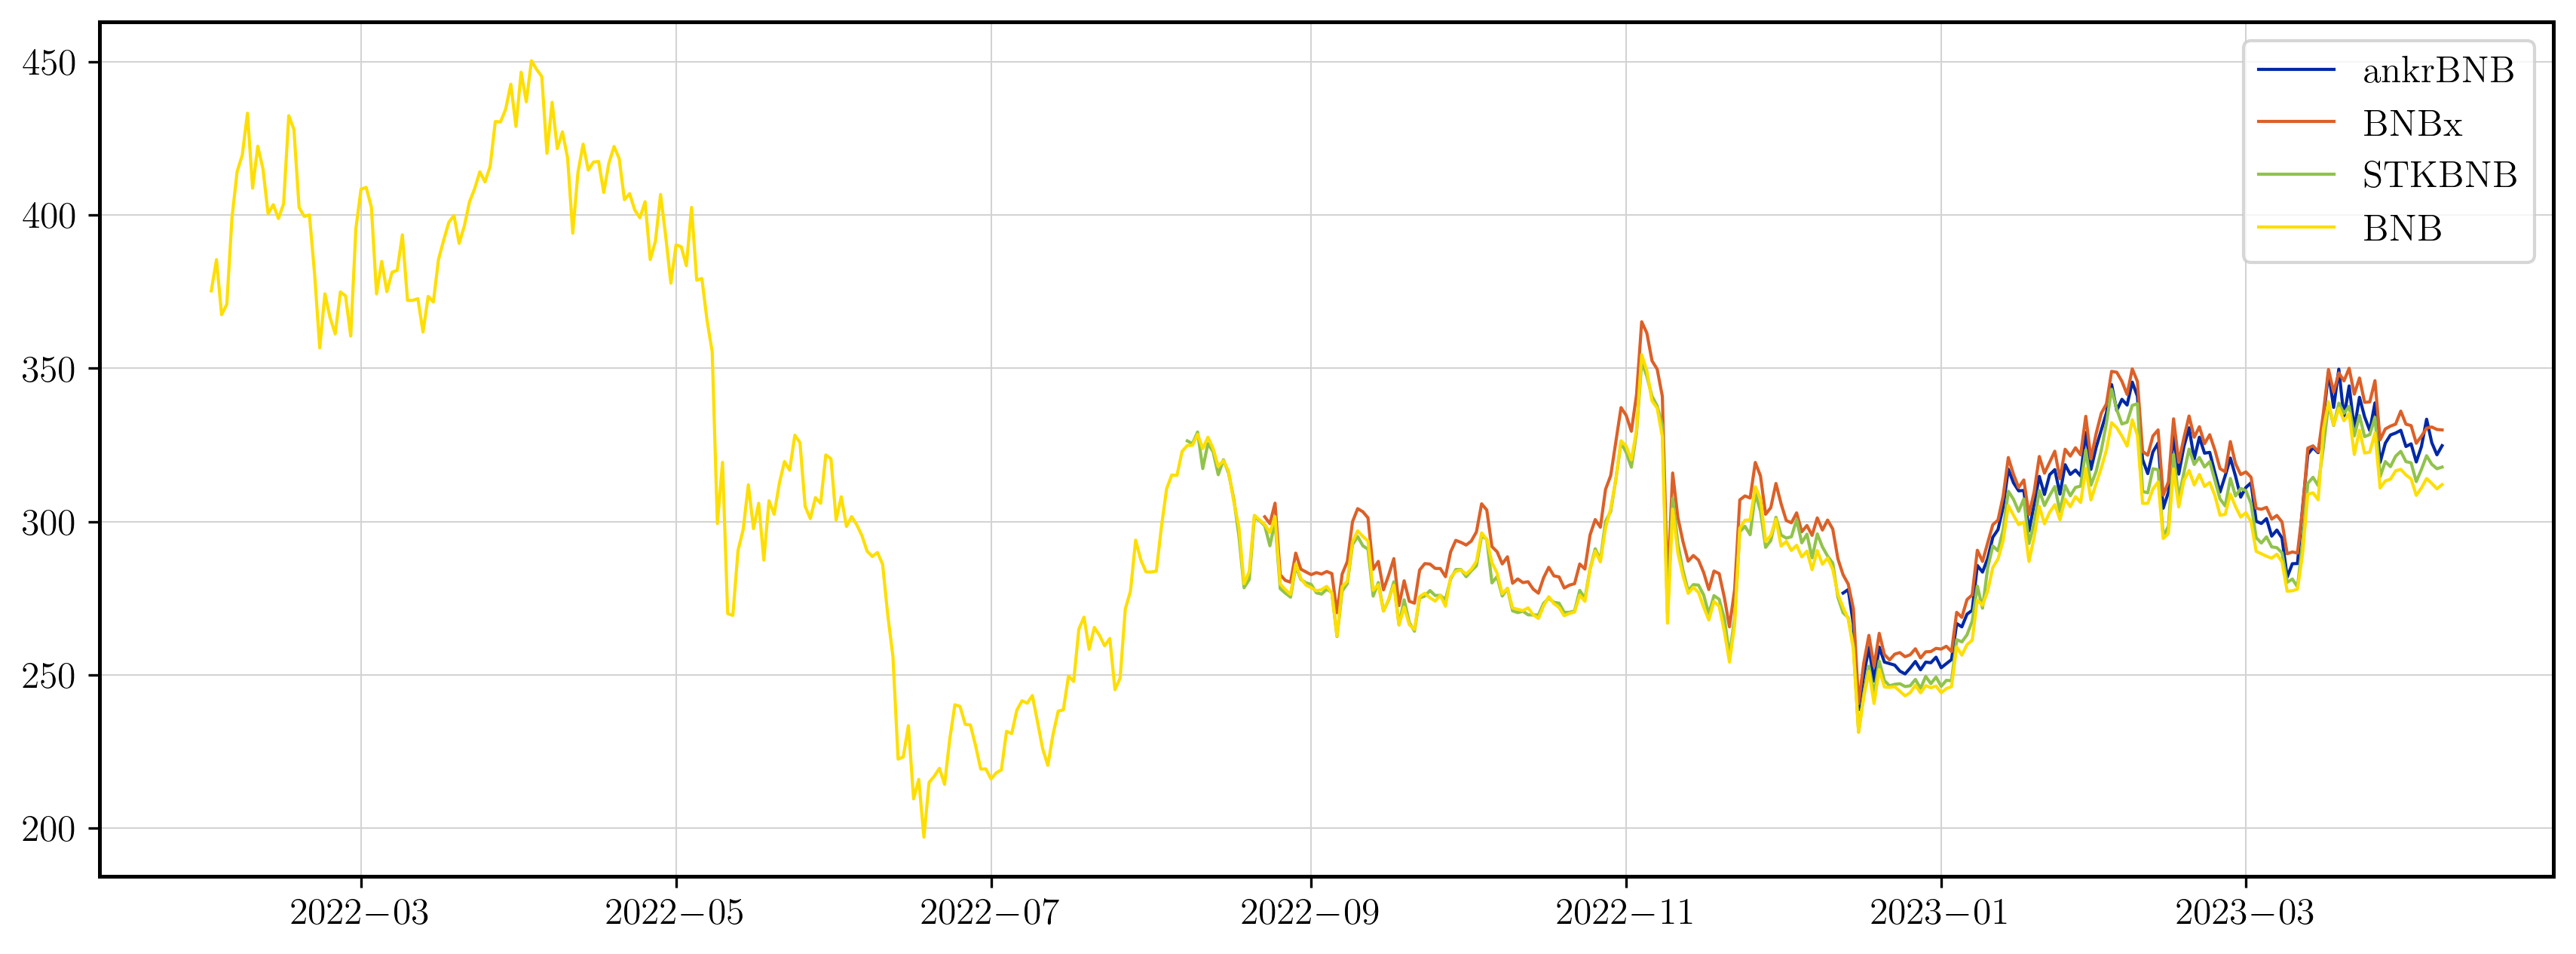

In [4]:

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for cur in data_xlsx:
    ax.plot(cur.index, cur.close, lw=1, label = cur.token)

ax.set_axisbelow(True)
#ax.set_xlim(reth_fair.index.min(), reth_fair.index.max())
#ax.set_ylim(1,1.1)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

plt.show()

In [5]:
result = pd.concat([d.close for d in data_xlsx], axis=1, join="outer", keys= [d.token for d in data_xlsx])
#interest = result[[maincurrency]].copy()
#interest['daily']= 0.07 
#interest.drop([maincurrency],inplace=True, axis=1)


result = result.div(result[maincurrency].values,axis=0)
result = result.drop(maincurrency, axis=1)
result.dropna(axis = 0, how = 'all', inplace = True)

interest = result.copy()
interest['daily']= 0.03

interest = pd.DataFrame(interest['daily'])

BNB_data=pd.read_csv('data/bnb-usd-max.csv')
BNB_data['snapped_at']=pd.to_datetime(BNB_data['snapped_at'])
BNB_data=BNB_data.set_index('snapped_at')
BNB_data.index.name = 'time'
BNB_data = BNB_data.tz_localize(None)
interest['daily']=(1+np.array(interest['daily']))**(1/365)
interest['daily_accrued']= interest['daily'].cumprod()
interest = pd.concat([interest, BNB_data], axis=1, join="outer")

interest['daily_BNB_change']=interest['price'].pct_change(1)
interest['daily_accrued_BNB']= (1+interest['daily_BNB_change']).cumprod()
interest['monthly_BNB_std'] = interest['daily_BNB_change'].rolling(30).std()
interest['daily_BNB_std_change'] = interest['monthly_BNB_std'].pct_change(1)
interest = interest.dropna()
interest

,daily,daily_accrued,price,market_cap,total_volume,daily_BNB_change,daily_accrued_BNB,monthly_BNB_std,daily_BNB_std_change
2022-08-08,1.000081,1.000081,323.233394,5.273961e+10,5.242590e+08,0.024463,3013.813639,0.033435,0.002657
2022-08-09,1.000081,1.000162,324.931021,5.300222e+10,9.461662e+08,0.005252,3029.642232,0.033413,-0.000641
2022-08-10,1.000081,1.000243,325.521822,5.319296e+10,1.186836e+09,0.001818,3035.150830,0.032400,-0.030331
2022-08-11,1.000081,1.000324,327.768511,5.349141e+10,2.476423e+08,0.006902,3056.098859,0.031069,-0.041073
2022-08-12,1.000081,1.000405,323.649851,5.285022e+10,4.653530e+08,-0.012566,3017.696658,0.030839,-0.007402
...,...,...,...,...,...,...,...,...,...
2023-04-04,1.000081,1.019626,308.846088,4.883499e+10,7.475714e+08,-0.016764,2879.667040,0.027050,0.008122
2023-04-05,1.000081,1.019709,310.988228,4.908711e+10,6.598402e+08,0.006936,2899.640253,0.027048,-0.000070
2023-04-06,1.000081,1.019791,314.276761,4.964163e+10,6.010759e+08,0.010574,2930.302390,0.027067,0.000715
2023-04-07,1.000081,1.019874,312.368648,4.931581e+10,4.904008e+08,-0.006071,2912.511230,0.027120,0.001941


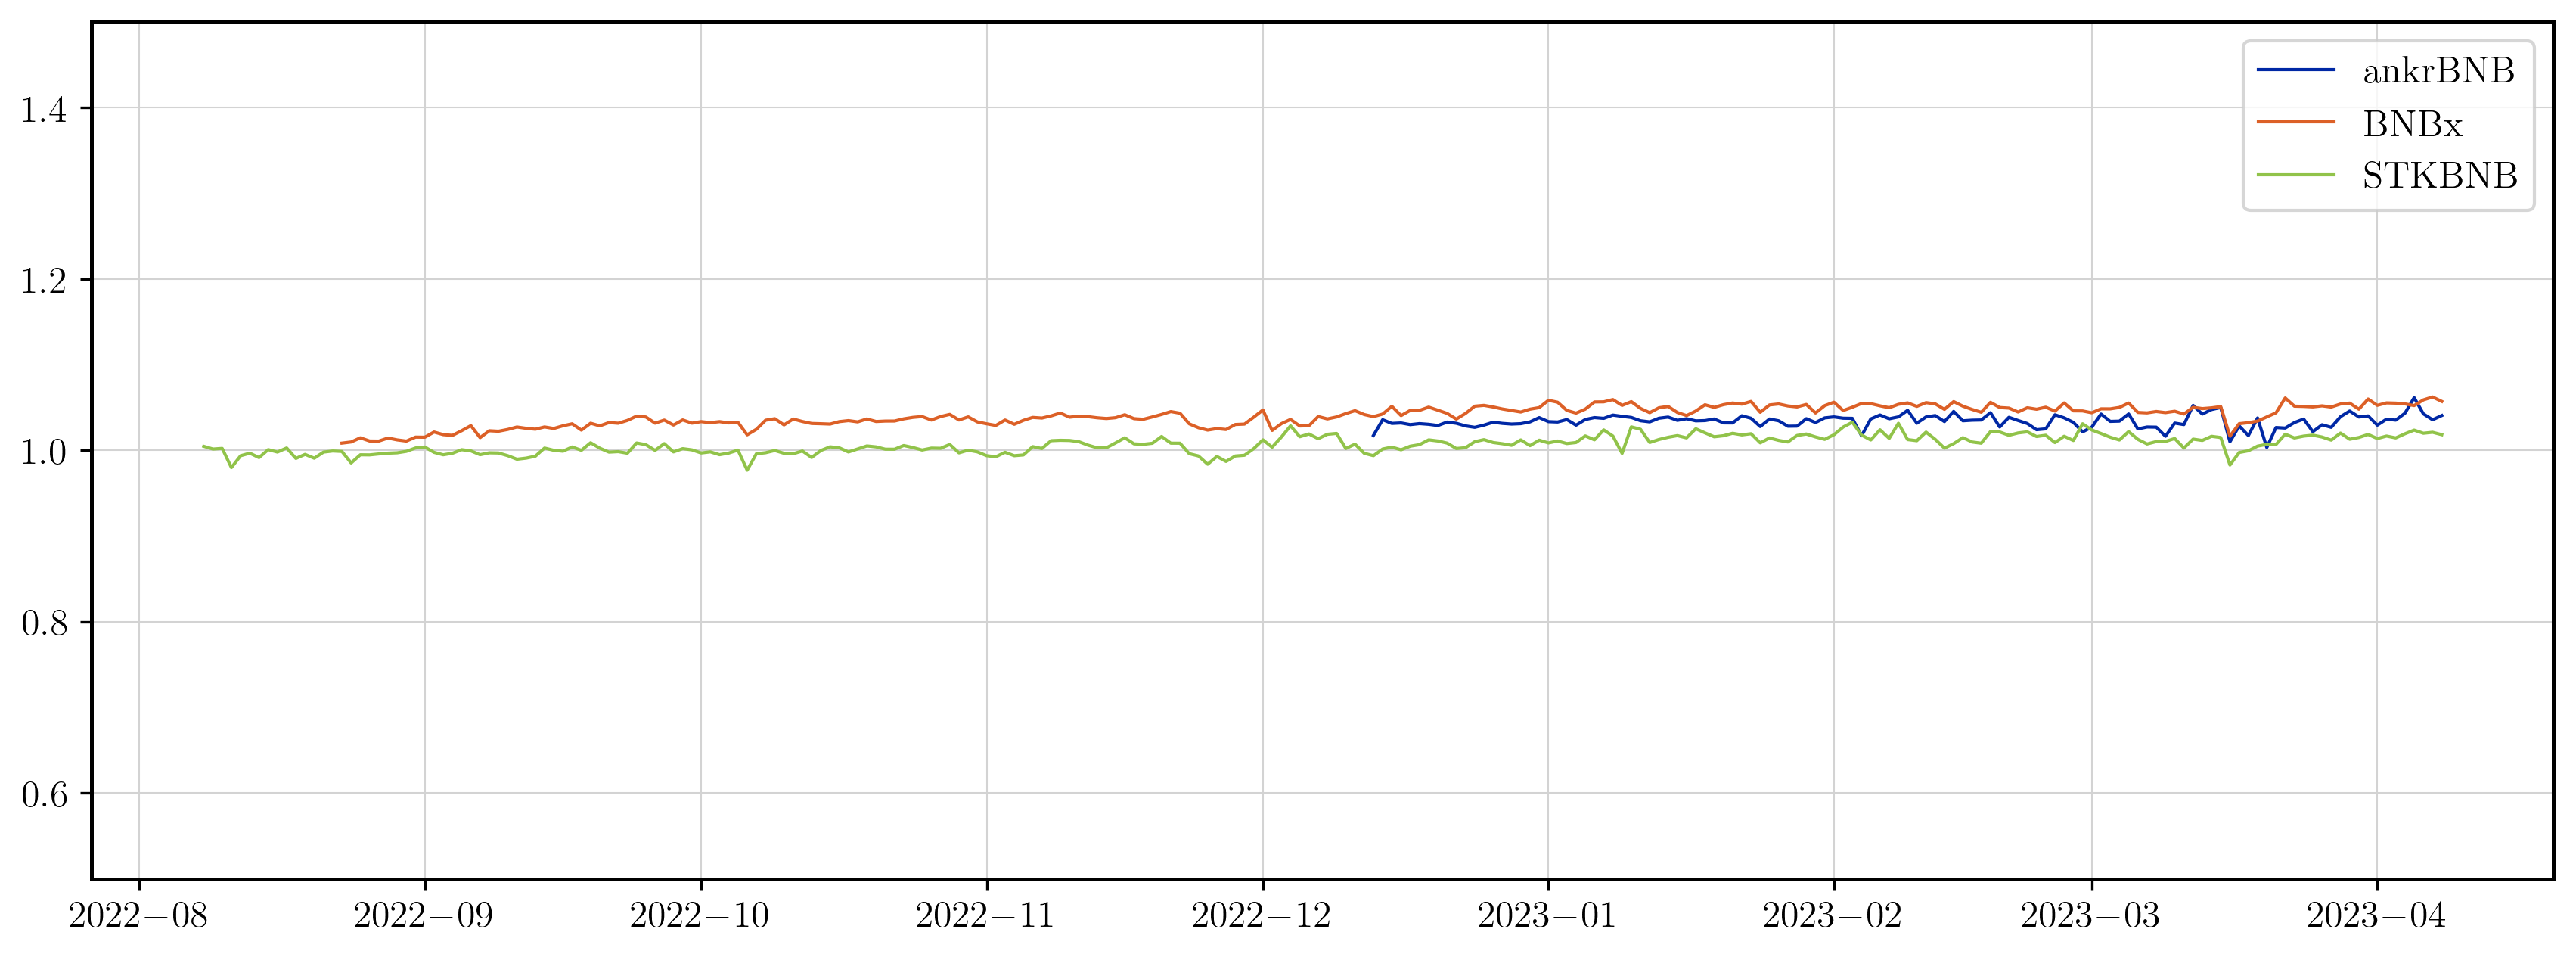

In [6]:

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in result.columns:
    ax.plot(result.index, result[col], lw=1, label = col)

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
ax.set_ylim(0.5,1.5)
fig.set_facecolor('w')

plt.show()

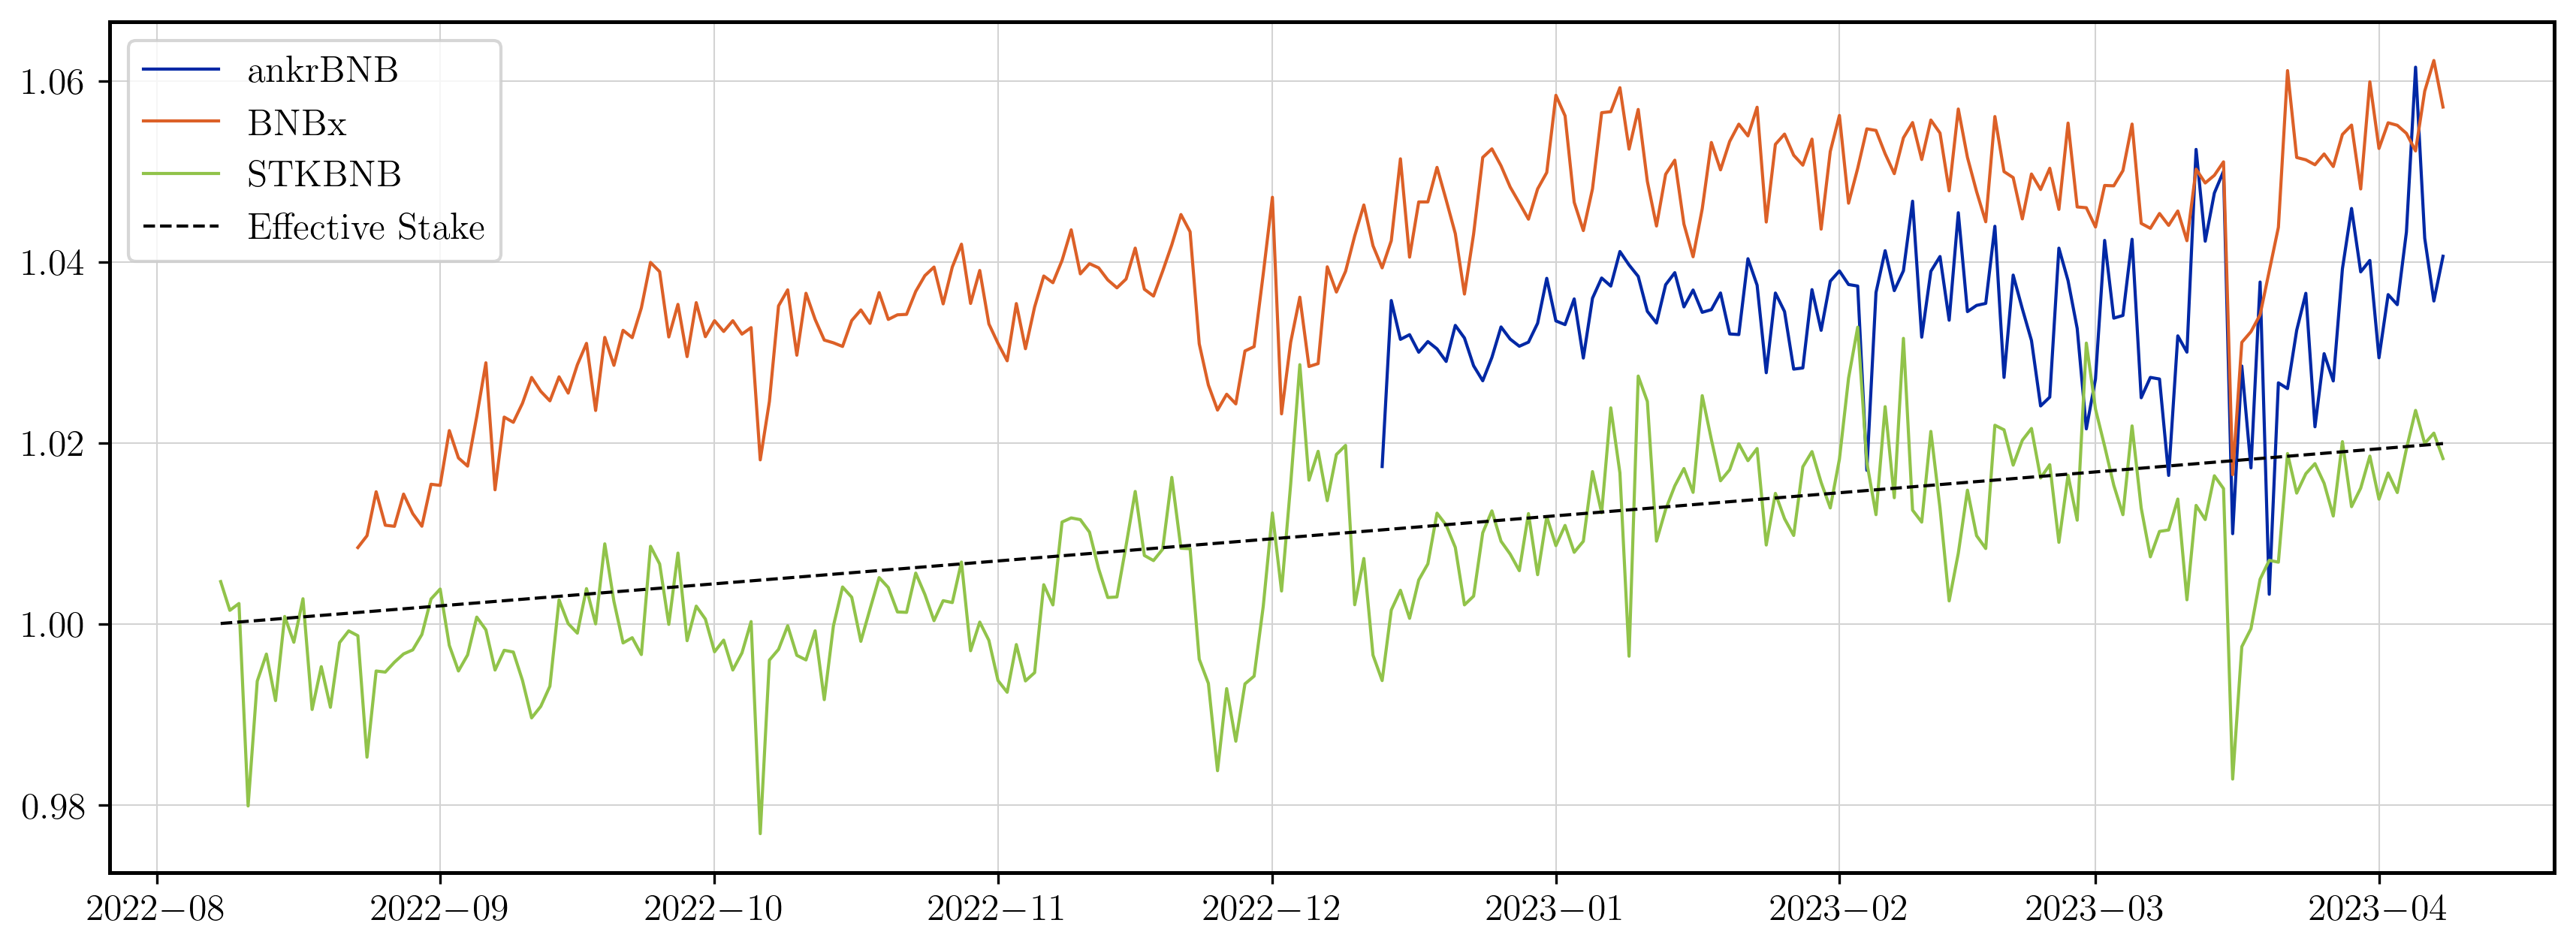

In [7]:

fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in result.columns:
    ax.plot(result.index, result[col], lw=1, label = col)

ax.plot(result.index, interest['daily_accrued'], color='k', lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

plt.show()

In [8]:
result_with_interest = pd.concat([result, interest.daily], axis=1, join="outer")
#result_with_interest.dropna(subset=['wstETH'], inplace=True)
result_with_interest['daily_accrued']= result_with_interest['daily'].cumprod()

In [9]:
result_with_interest

,ankrBNB,BNBx,STKBNB,daily,daily_accrued
2022-08-08,NaN,NaN,1.004712,1.000081,1.000081
2022-08-09,NaN,NaN,1.001531,1.000081,1.000162
2022-08-10,NaN,NaN,1.002287,1.000081,1.000243
2022-08-11,NaN,NaN,0.979926,1.000081,1.000324
2022-08-12,NaN,NaN,0.993712,1.000081,1.000405
...,...,...,...,...,...
2023-04-04,1.043331,1.054219,1.019368,1.000081,1.019626
2023-04-05,1.061530,1.052279,1.023620,1.000081,1.019709
2023-04-06,1.042636,1.058886,1.019967,1.000081,1.019791
2023-04-07,1.035703,1.062270,1.021106,1.000081,1.019874


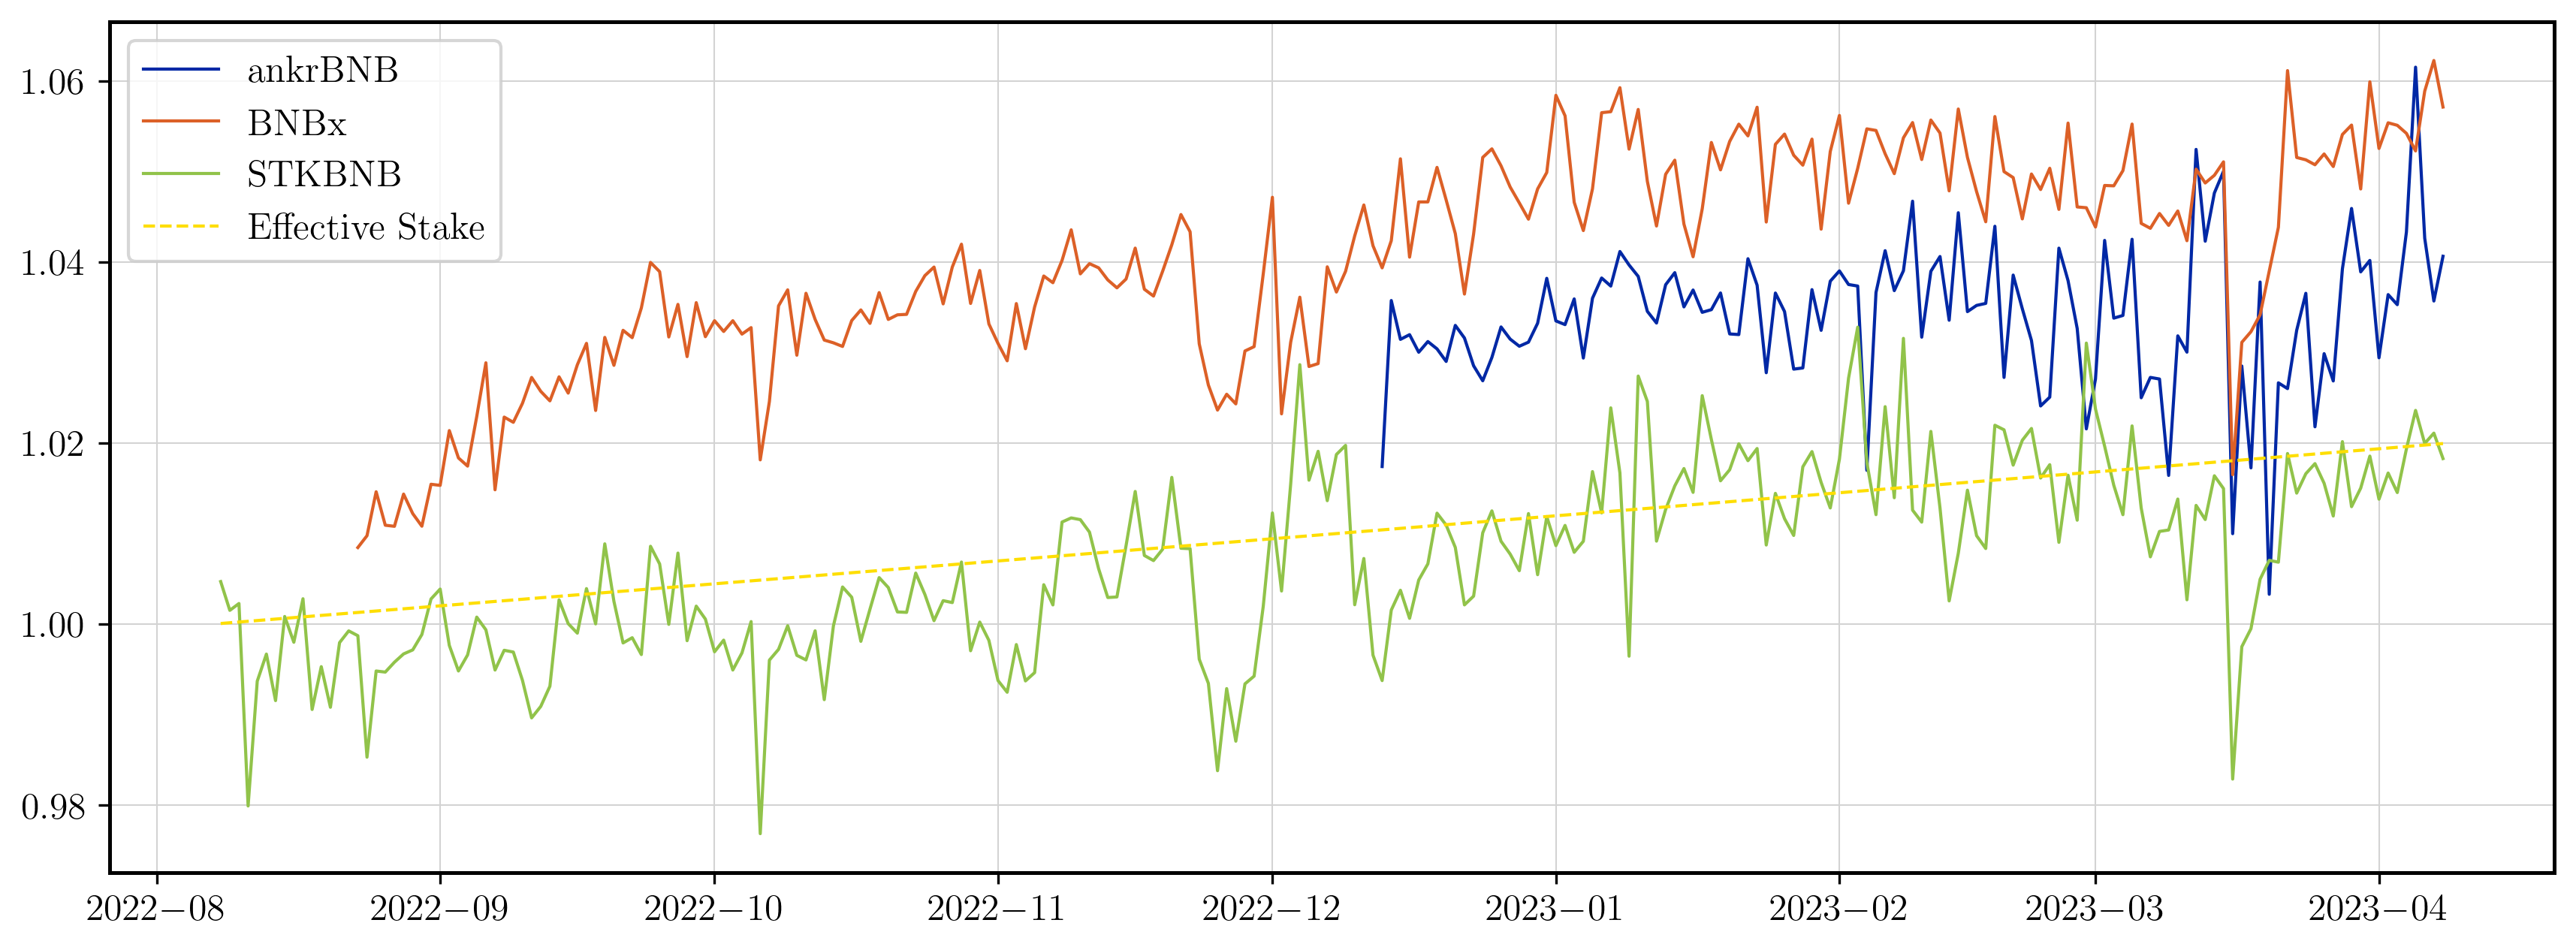

In [10]:
data_to_plot = result_with_interest
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.plot(data_to_plot.index, data_to_plot[col].rolling(window=1).mean(), lw=1, label = col)

ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [11]:
data_to_plot = result_with_interest
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col == 'daily':
        continue
    ax.scatter(data_to_plot.index, data_to_plot[col].pct_change(1), s=1,lw=1, label = col)

ax.plot(data_to_plot.index, data_to_plot['daily']-1, lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

RuntimeError: latex was not able to process the following string:
b'daily_accrued'

Here is the full report generated by latex:
This is pdfTeX, Version 3.141592653-2.6-1.40.24 (MiKTeX 22.10) (preloaded format=latex.fmt)
 restricted \write18 enabled.
entering extended mode
(C:/Users/malte/.matplotlib/tex.cache/5b17e5b9967a3f1e431cc7173c99e13d.tex
LaTeX2e <2022-06-01> patch level 5
L3 programming layer <2022-09-28>
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/base\article.cls
Document Class: article 2021/10/04 v1.4n Standard LaTeX document class
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/base\size10.clo))
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/type1cm\type1cm.sty)
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/cm-super\type1ec.sty
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/base\t1cmr.fd))
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/base\inputenc.sty)
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.sty
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/graphics\keyval.sty)
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/generic/iftex\ifvtex.sty
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/generic/iftex\iftex.sty))
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/geometry\geometry.cfg))
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/base\textcomp.sty)
(C:\Users\malte\AppData\Local\Programs\MiKTeX\tex/latex/l3backend\l3backend-dvi
ps.def)
No file 5b17e5b9967a3f1e431cc7173c99e13d.aux.
*geometry* driver: auto-detecting
*geometry* detected driver: dvips
! Missing $ inserted.
<inserted text> 
                $
l.19 {\rmfamily daily_
                      accrued}
No pages of output.
Transcript written on 5b17e5b9967a3f1e431cc7173c99e13d.log.




<Figure size 4200x1500 with 1 Axes>

In [12]:
data_to_plot.pct_change(1).describe()

,ankrBNB,BNBx,STKBNB,daily,daily_accrued
count,116.000000,228.000000,243.000000,243.0,243.000000
mean,0.000240,0.000222,0.000082,0.0,0.000081
std,0.009505,0.005611,0.007324,0.0,0.000000
min,-0.038124,-0.032877,-0.031614,0.0,0.000081
25%,-0.003658,-0.002370,-0.003591,0.0,0.000081
50%,0.000171,0.000479,0.000063,0.0,0.000081
75%,0.004880,0.003497,0.004210,0.0,0.000081
max,0.023277,0.016580,0.031051,0.0,0.000081


In [13]:
#df[df['A'].isnull()].index.tolist()

In [33]:
interest_band = result.copy()
interest_band['daily_upper']= 0.05 
interest_band['daily_lower']= 0.01

interest_band['daily_upper']=(1+np.array(interest_band['daily_upper']))**(1/365)
interest_band['daily_accrued_upper']= interest_band['daily_upper'].cumprod()

interest_band['daily_lower']=(1+np.array(interest_band['daily_lower']))**(1/365)
interest_band['daily_accrued_lower']= interest_band['daily_lower'].cumprod()

In [34]:
_df = result_with_interest.copy()
adjusted_results = result_with_interest.copy()
for col in tokens:
    adjusted_results[col]= (adjusted_results[col]/_df.loc[(min(_df[_df[col].notnull()].index.tolist()))][col])*_df.loc[(min(_df[_df[col].notnull()].index.tolist()))]['daily_accrued']


    

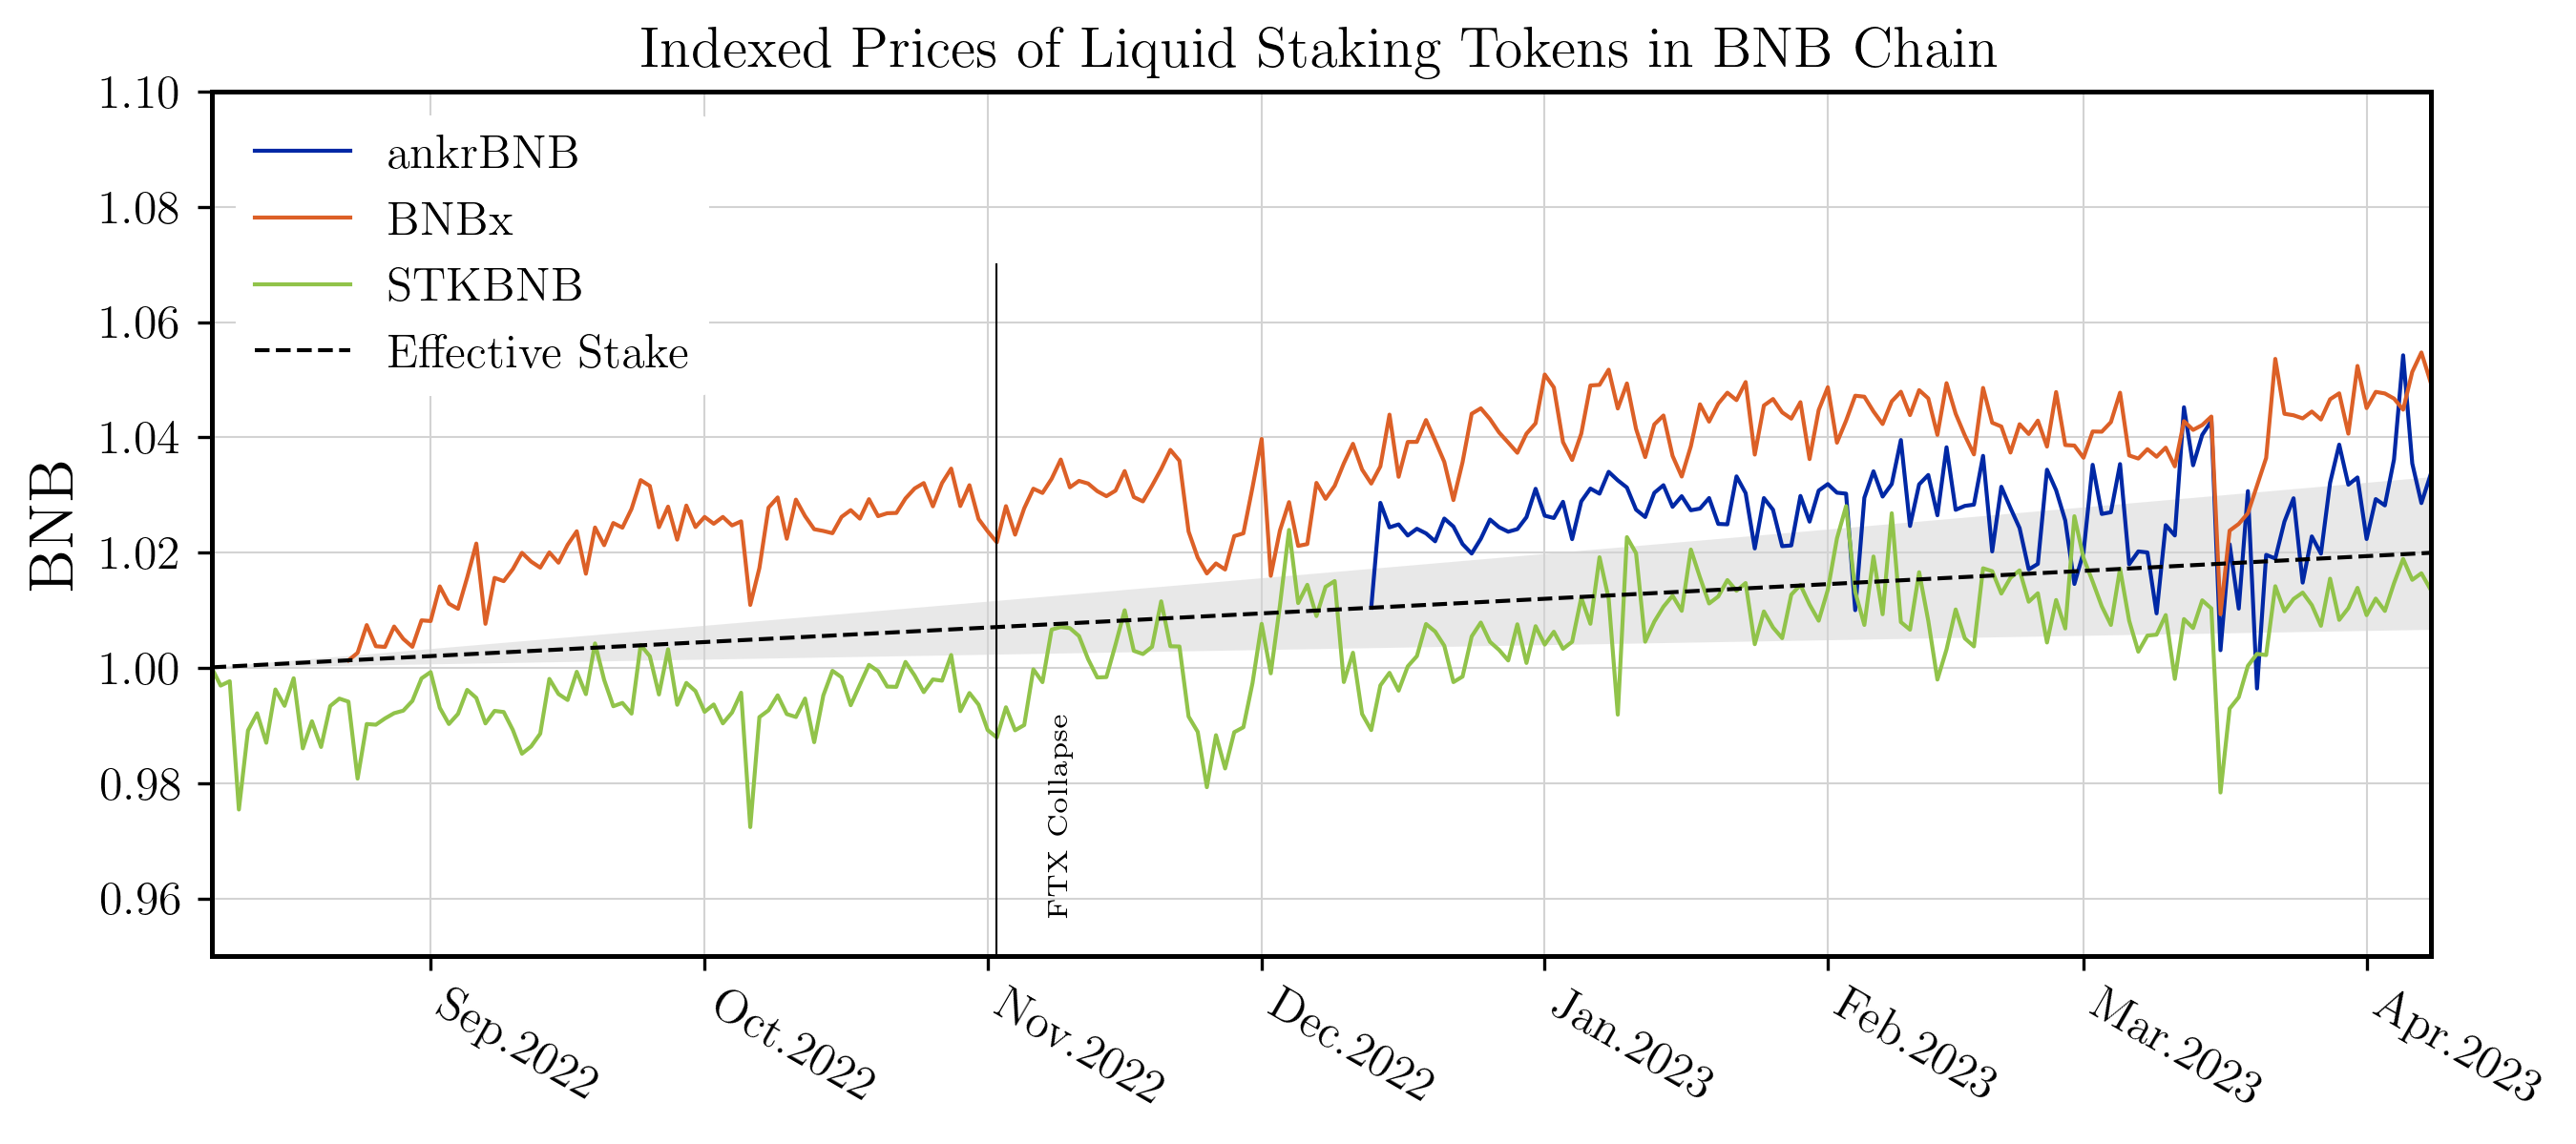

In [35]:
data_to_plot = adjusted_results
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(10,4),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.plot(data_to_plot.index, data_to_plot[col], lw=1, label = col)

ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], color = 'k', lw=1, ls='--', label='Effective Stake')
ax.fill_between(interest_band.index, interest_band['daily_accrued_lower'], interest_band['daily_accrued_upper'], color = 'lightgray', alpha = 0.5, lw=0)

add_terra_and_ftx(ax, 'ftx')

ax.set_title('Indexed Prices of Liquid Staking Tokens in BNB Chain')
ax.set_ylabel('BNB')

leg = ax.legend(frameon=True,facecolor='white', framealpha=1)
frame = leg.get_frame()
frame.set_linewidth(0)

# Text in the x-axis will be displayed in 'YYYY-mm' format.
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b. %Y'))
# Rotates and right-aligns the x labels so they don't crowd each other.
for label in ax.get_xticklabels(which='major'):
    label.set(rotation=-30, horizontalalignment='left')


#ax.set_ylim(0.6,1.2)
ax.set_xlim(min(data_to_plot.index),max(data_to_plot.index))
ax.set_ylim(0.95, 1.1)
ax.set_axisbelow(True)
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [17]:
df1 =  adjusted_results



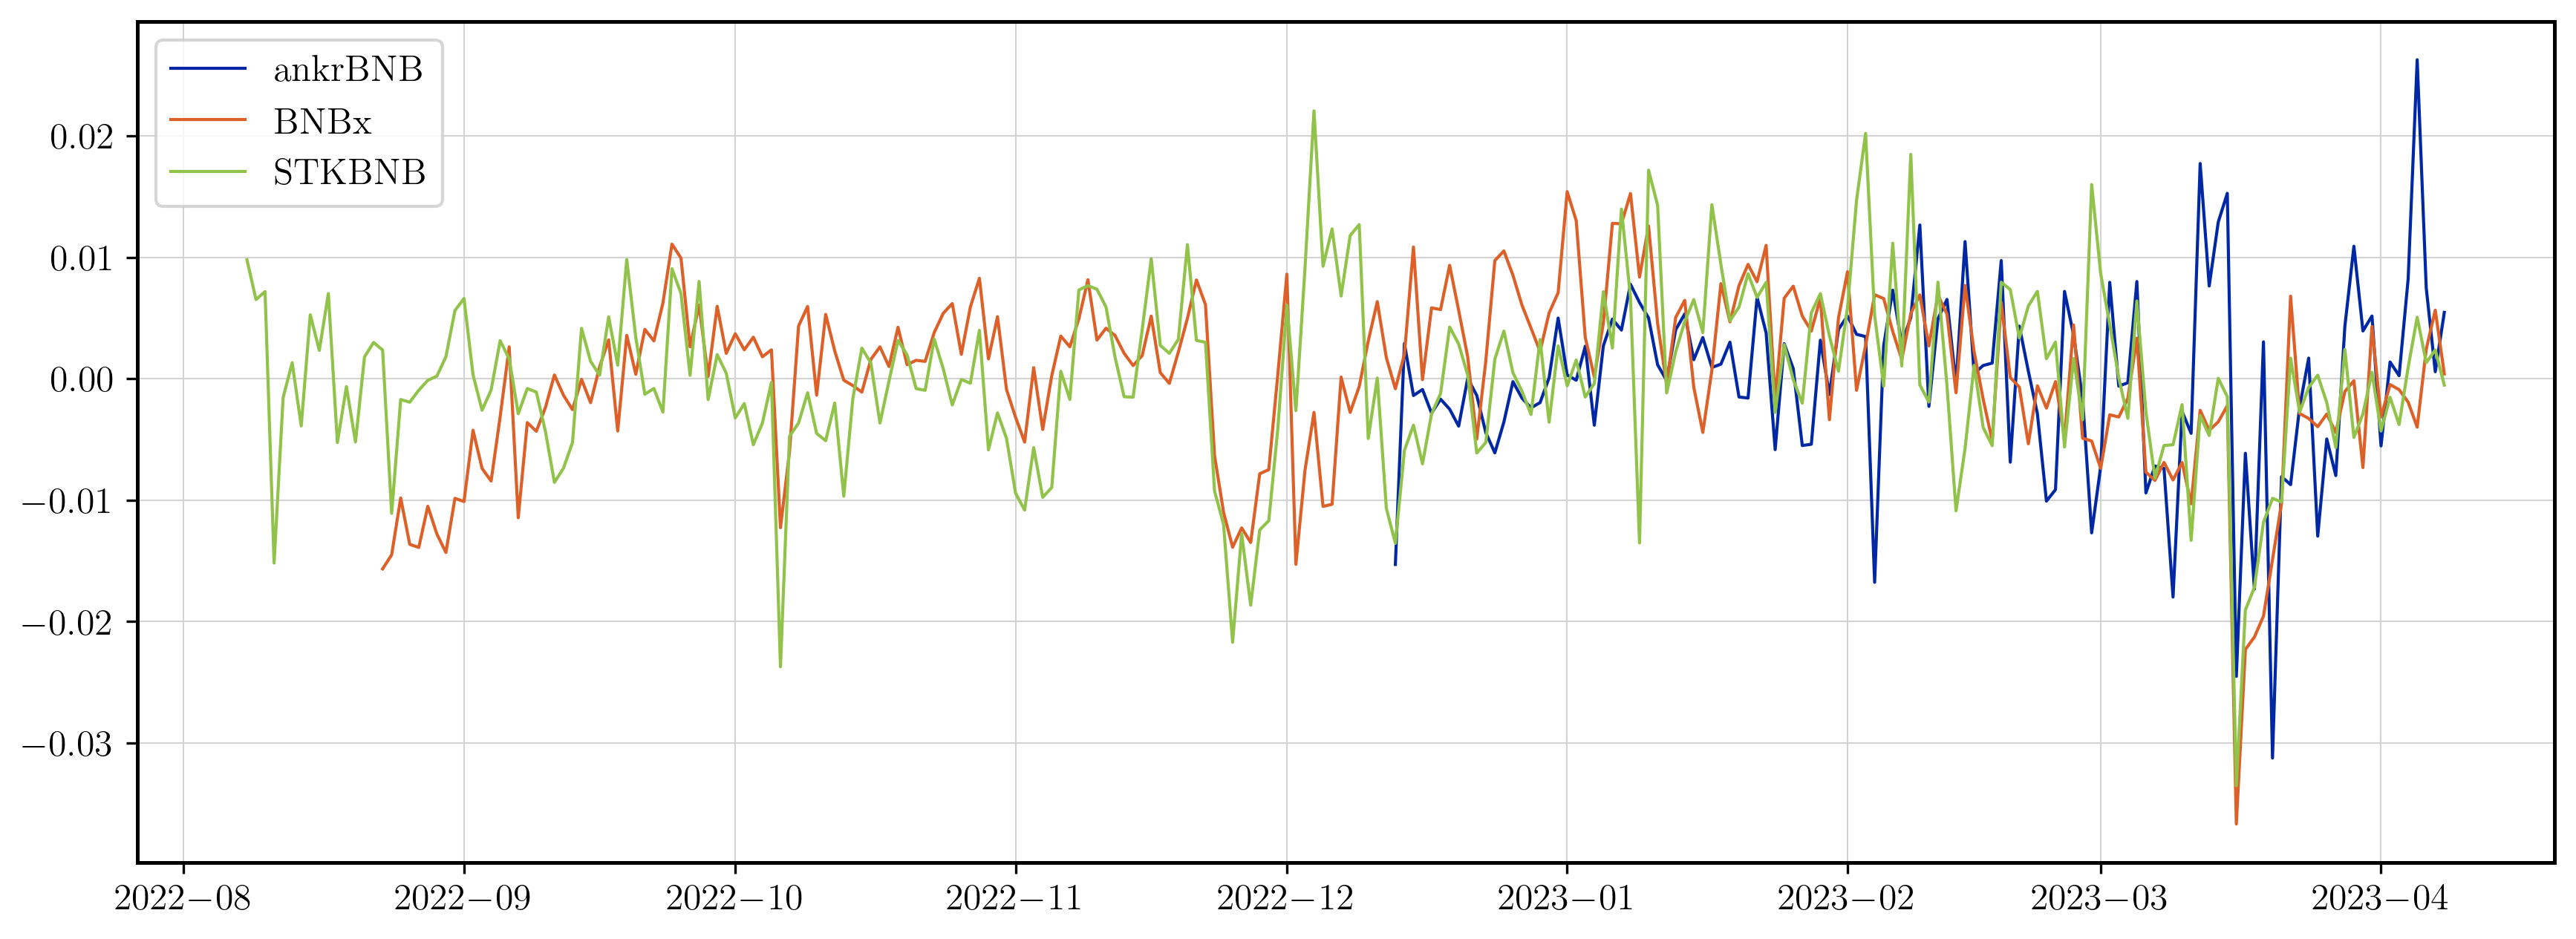

In [36]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = adjusted_results
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.plot(data_to_plot[data_to_plot[col].notnull()].index, signal.detrend(data_to_plot[data_to_plot[col].notnull()][col].values), lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [37]:
data_to_plot[data_to_plot[col].notnull()][col].values

array([1.00008099, 1.00016198, 1.00024298, 1.00032398, 1.000405  ,
       1.00048602, 1.00056704, 1.00064807, 1.00072911, 1.00081016,
       1.00089121, 1.00097227, 1.00105333, 1.00113441, 1.00121548,
       1.00129657, 1.00137766, 1.00145876, 1.00153986, 1.00162097,
       1.00170209, 1.00178321, 1.00186435, 1.00194548, 1.00202663,
       1.00210778, 1.00218893, 1.0022701 , 1.00235127, 1.00243244,
       1.00251363, 1.00259482, 1.00267601, 1.00275722, 1.00283843,
       1.00291964, 1.00300087, 1.00308209, 1.00316333, 1.00324457,
       1.00332582, 1.00340708, 1.00348834, 1.00356961, 1.00365088,
       1.00373217, 1.00381345, 1.00389475, 1.00397605, 1.00405736,
       1.00413867, 1.00422   , 1.00430132, 1.00438266, 1.004464  ,
       1.00454535, 1.0046267 , 1.00470806, 1.00478943, 1.00487081,
       1.00495219, 1.00503357, 1.00511497, 1.00519637, 1.00527777,
       1.00535919, 1.00544061, 1.00552204, 1.00560347, 1.00568491,
       1.00576636, 1.00584781, 1.00592927, 1.00601074, 1.00609

In [38]:
adjusted_results 

,ankrBNB,BNBx,STKBNB,daily,daily_accrued
2022-08-08,NaN,NaN,1.000081,1.000081,1.000081
2022-08-09,NaN,NaN,0.996914,1.000081,1.000162
2022-08-10,NaN,NaN,0.997668,1.000081,1.000243
2022-08-11,NaN,NaN,0.975409,1.000081,1.000324
2022-08-12,NaN,NaN,0.989132,1.000081,1.000405
...,...,...,...,...,...
2023-04-04,1.036155,1.046721,1.014669,1.000081,1.019626
2023-04-05,1.054229,1.044795,1.018902,1.000081,1.019709
2023-04-06,1.035464,1.051356,1.015266,1.000081,1.019791
2023-04-07,1.028579,1.054716,1.016399,1.000081,1.019874


In [39]:
_df = adjusted_results.copy()
excess_returns = adjusted_results.copy()
excess_returns['daily']=_df['daily']-1
for col in tokens:
    excess_returns[col] = _df[col].pct_change(1)

for col in tokens:
    excess_returns[col] =  excess_returns[excess_returns[col].notna()][col]-excess_returns['daily']



    

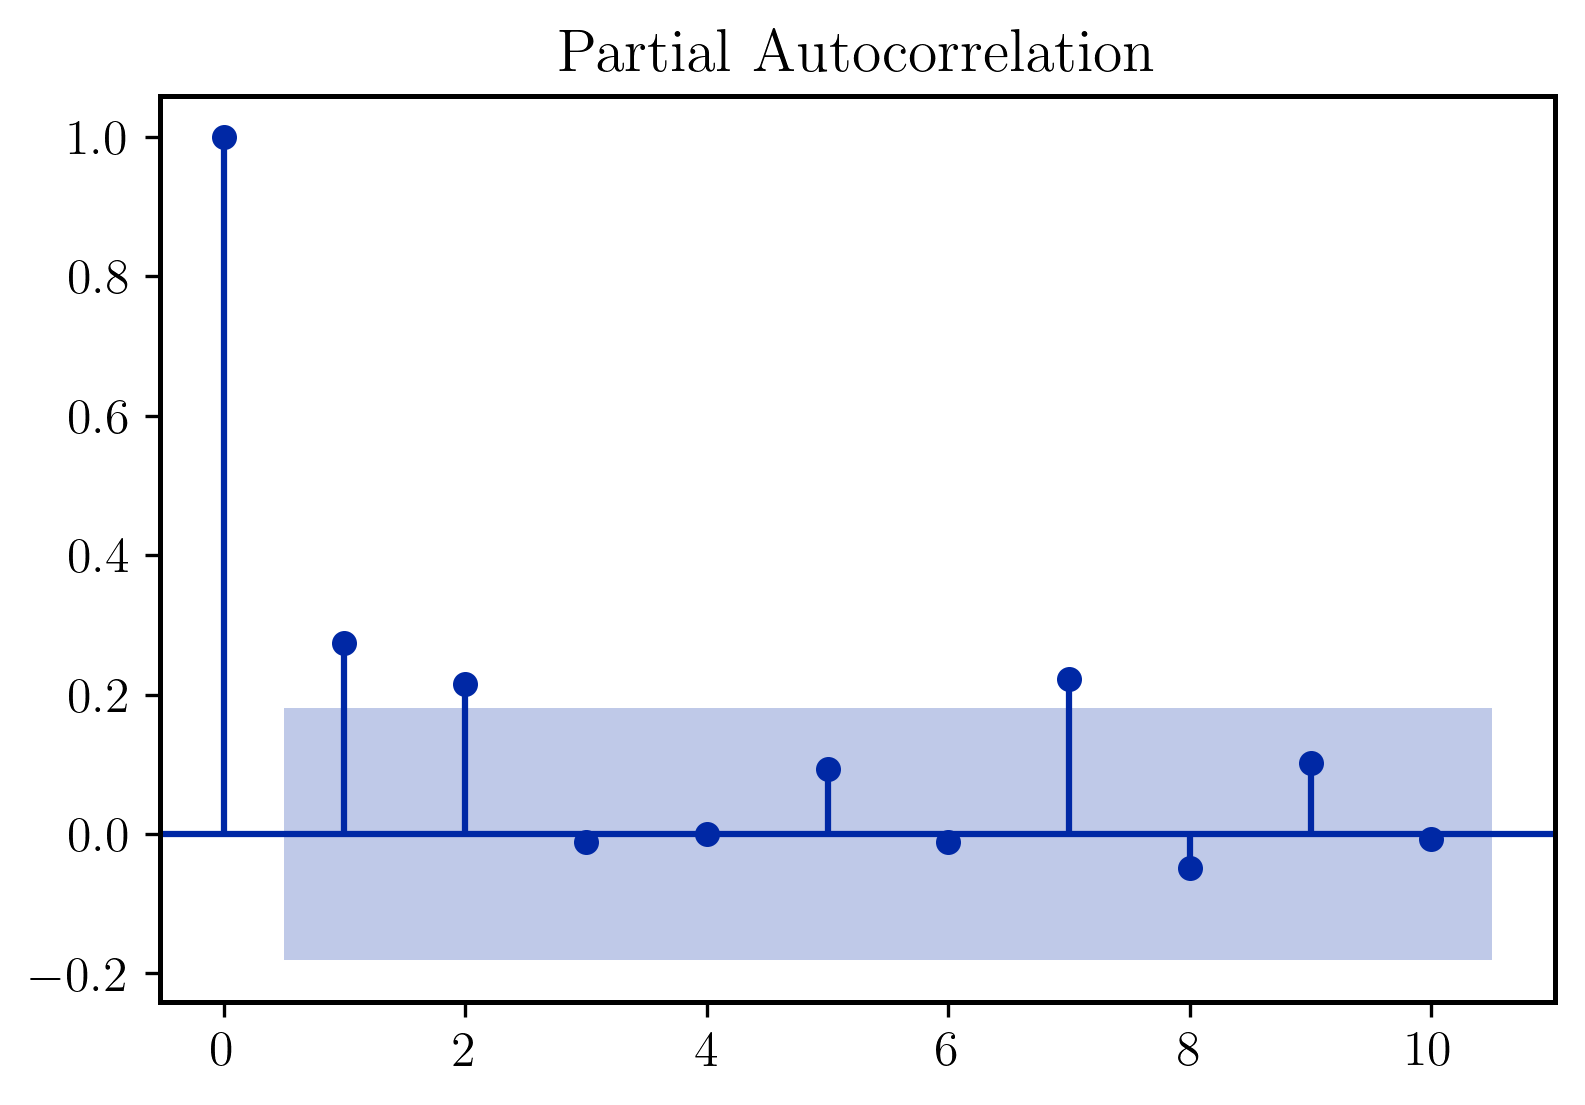

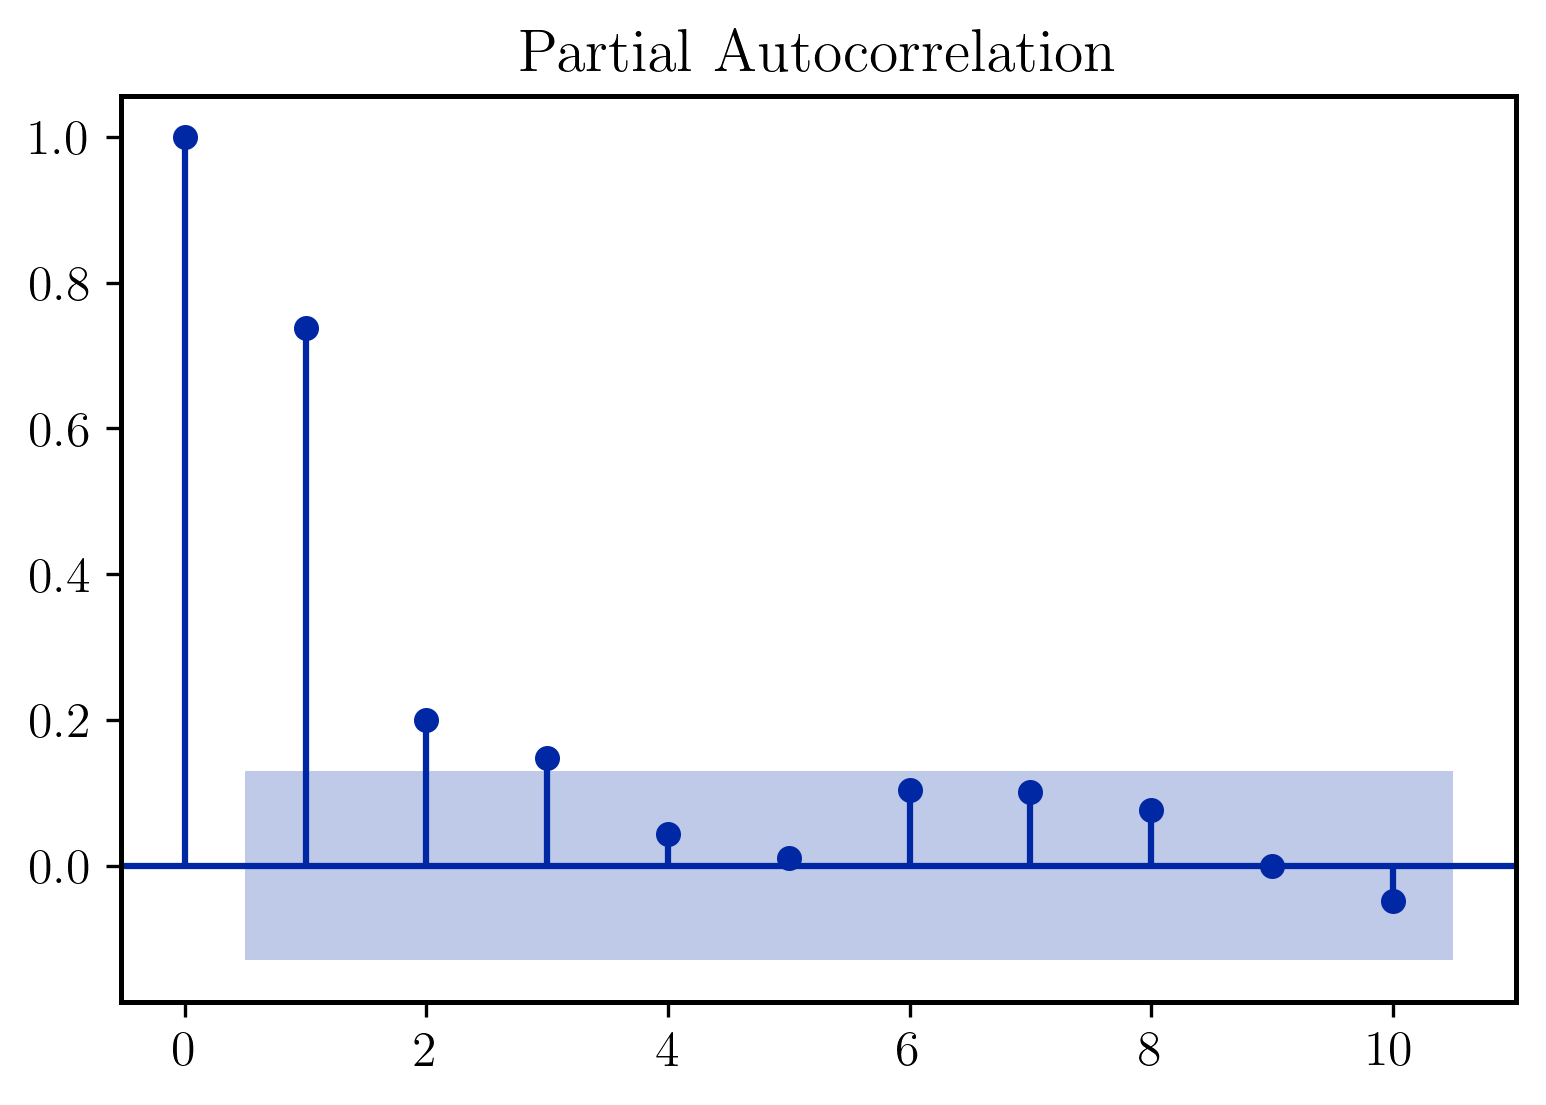

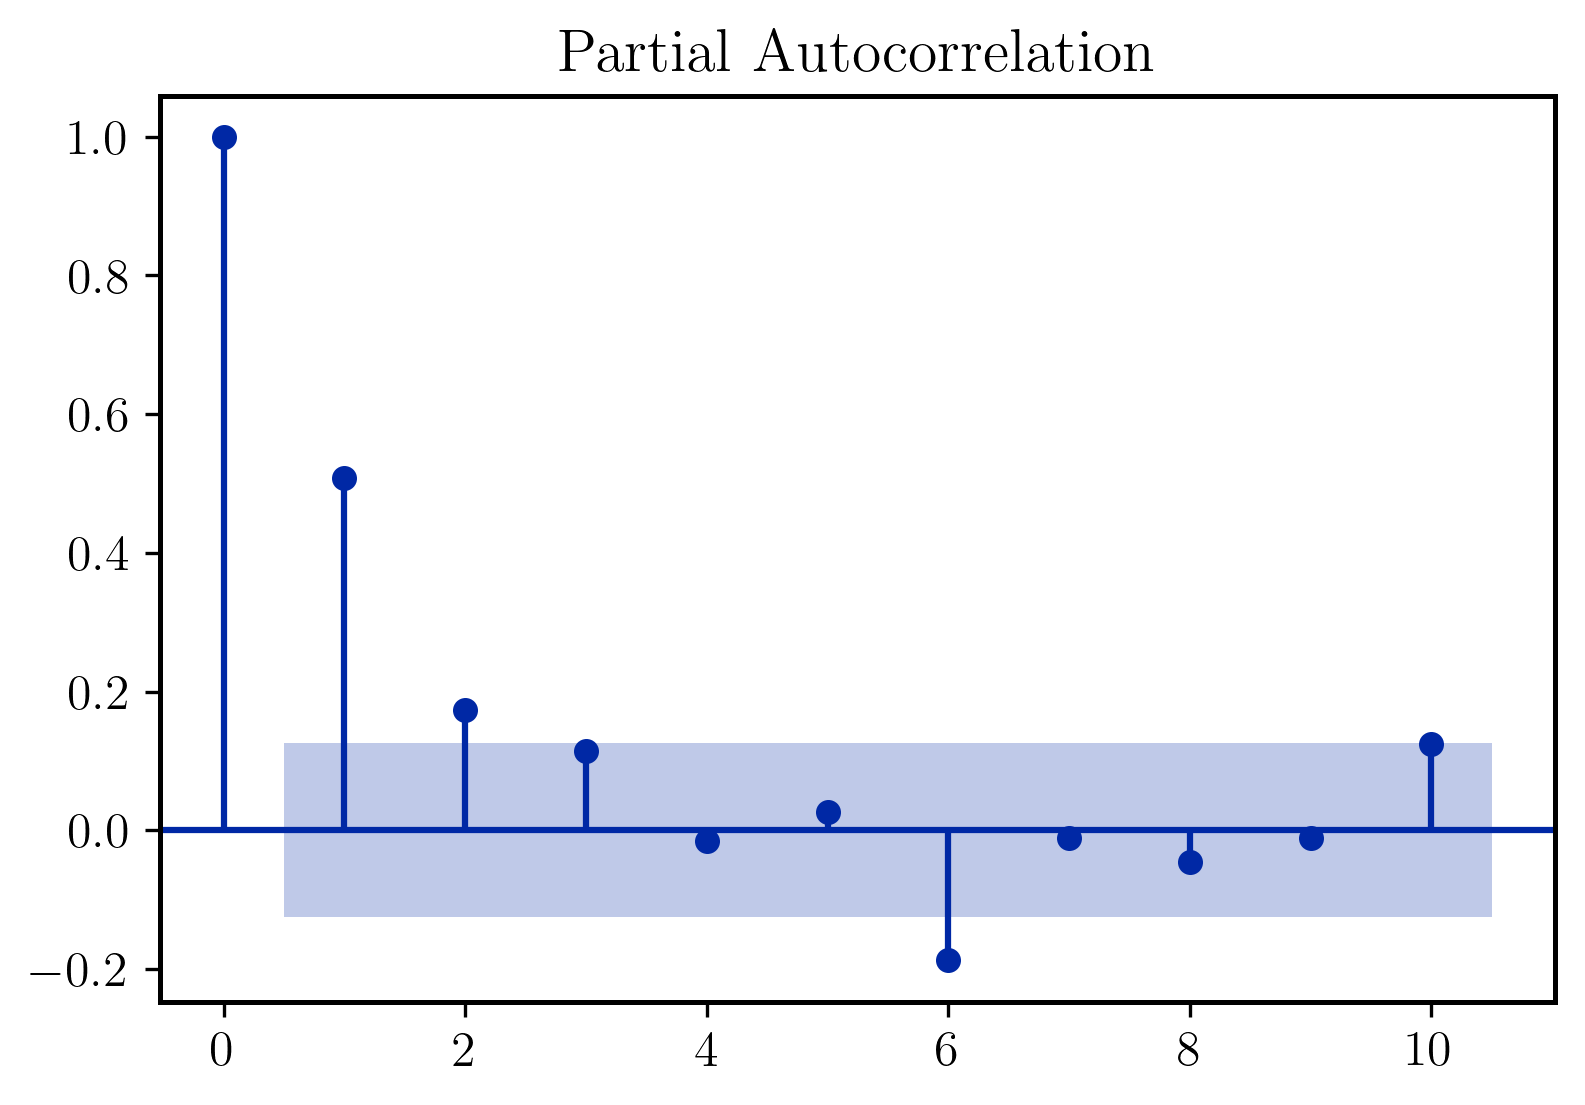

In [40]:
from statsmodels.graphics.tsaplots import plot_pacf
import matplotlib.pyplot as plt
_df = adjusted_results.copy()
ret_diff = adjusted_results.copy()
ret_diff['daily']=_df['daily']-1

for col in tokens:
    ret_diff[col] =  ret_diff[ret_diff[col].notna()][col]-ret_diff['daily_accrued']
    plot_pacf(ret_diff[col].dropna(), lags=10)
    plt.show()


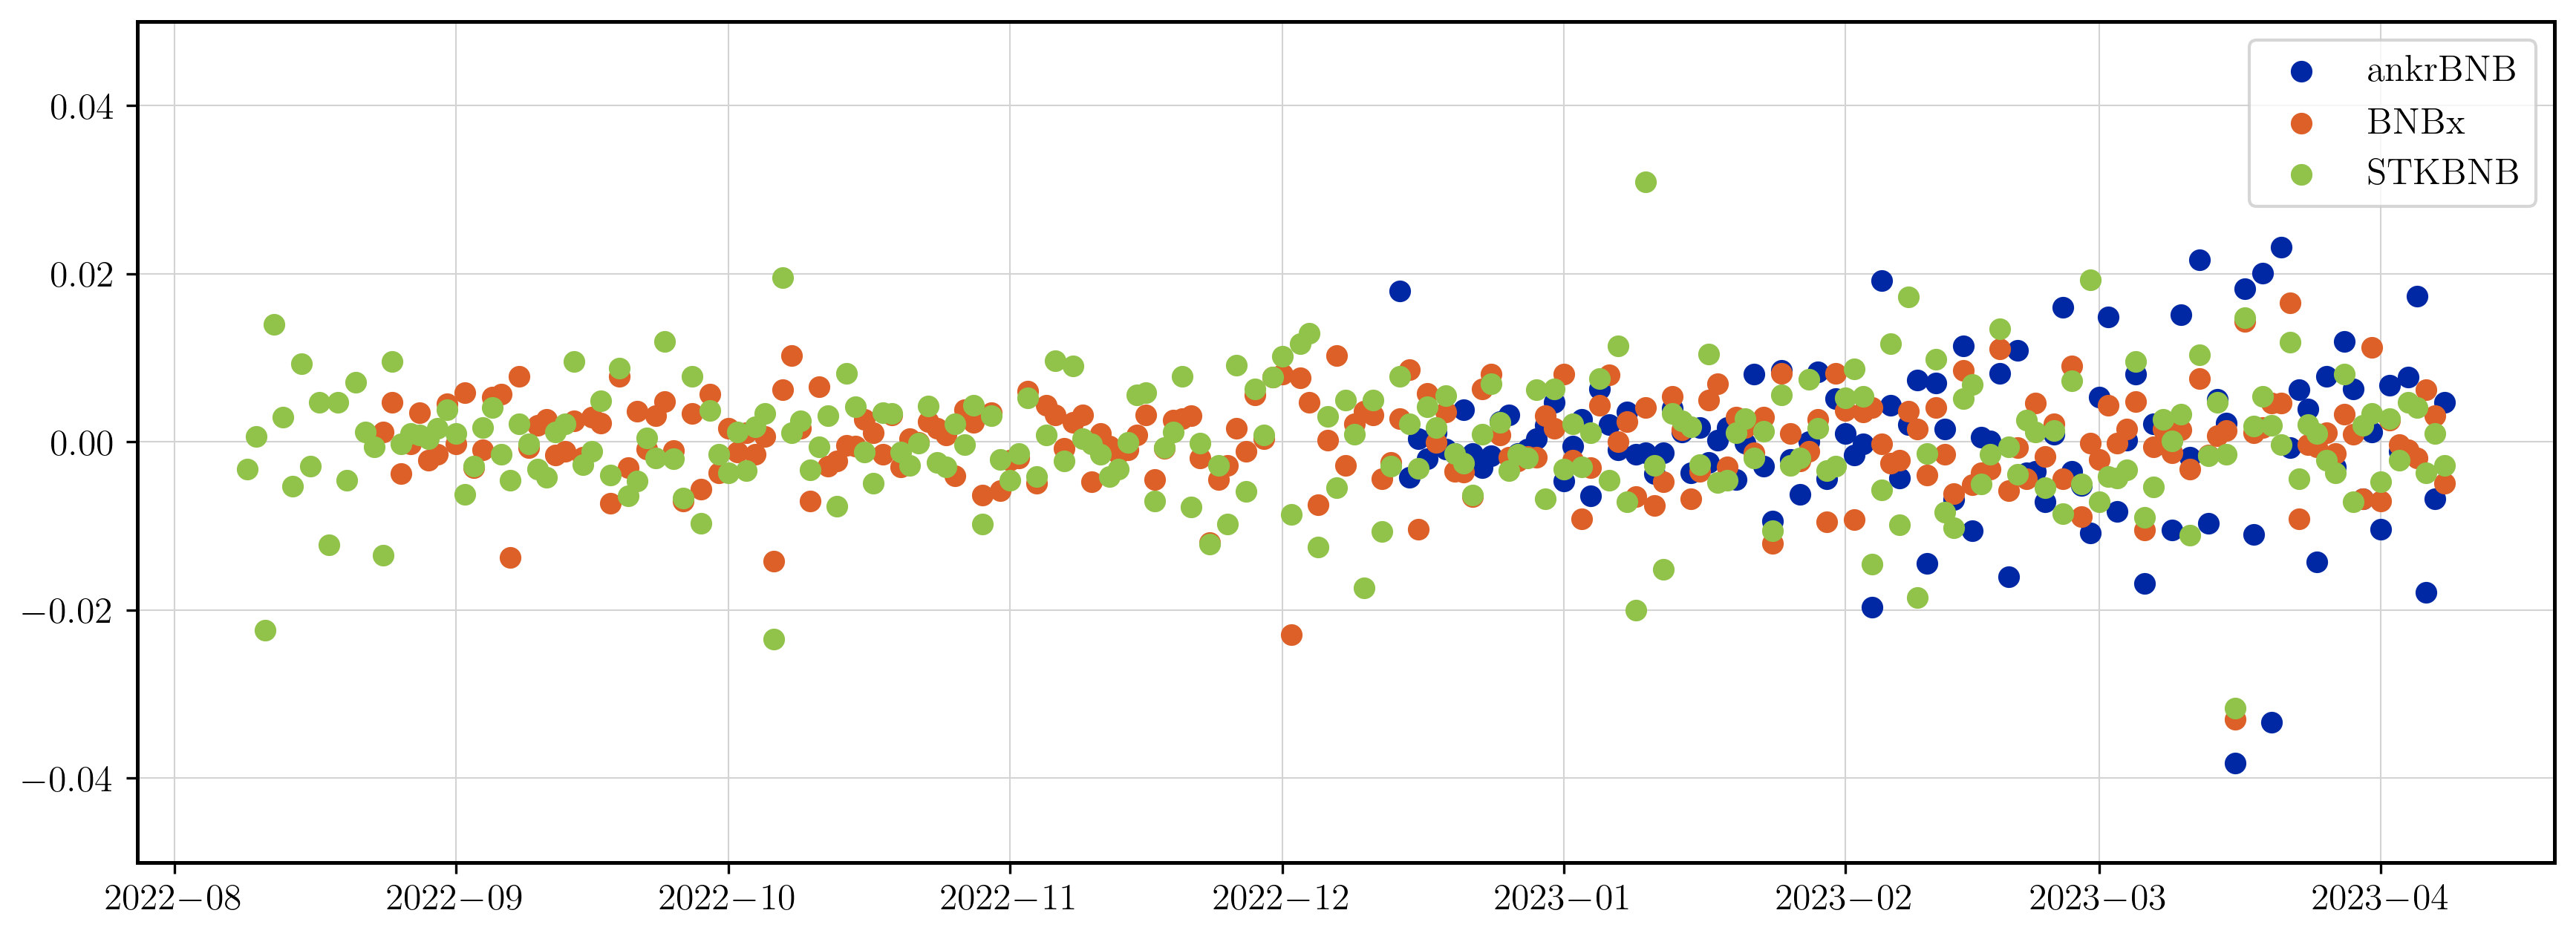

In [41]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = excess_returns
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.scatter(data_to_plot[col].index, data_to_plot[col], lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.set_ylim(-0.05,0.05)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

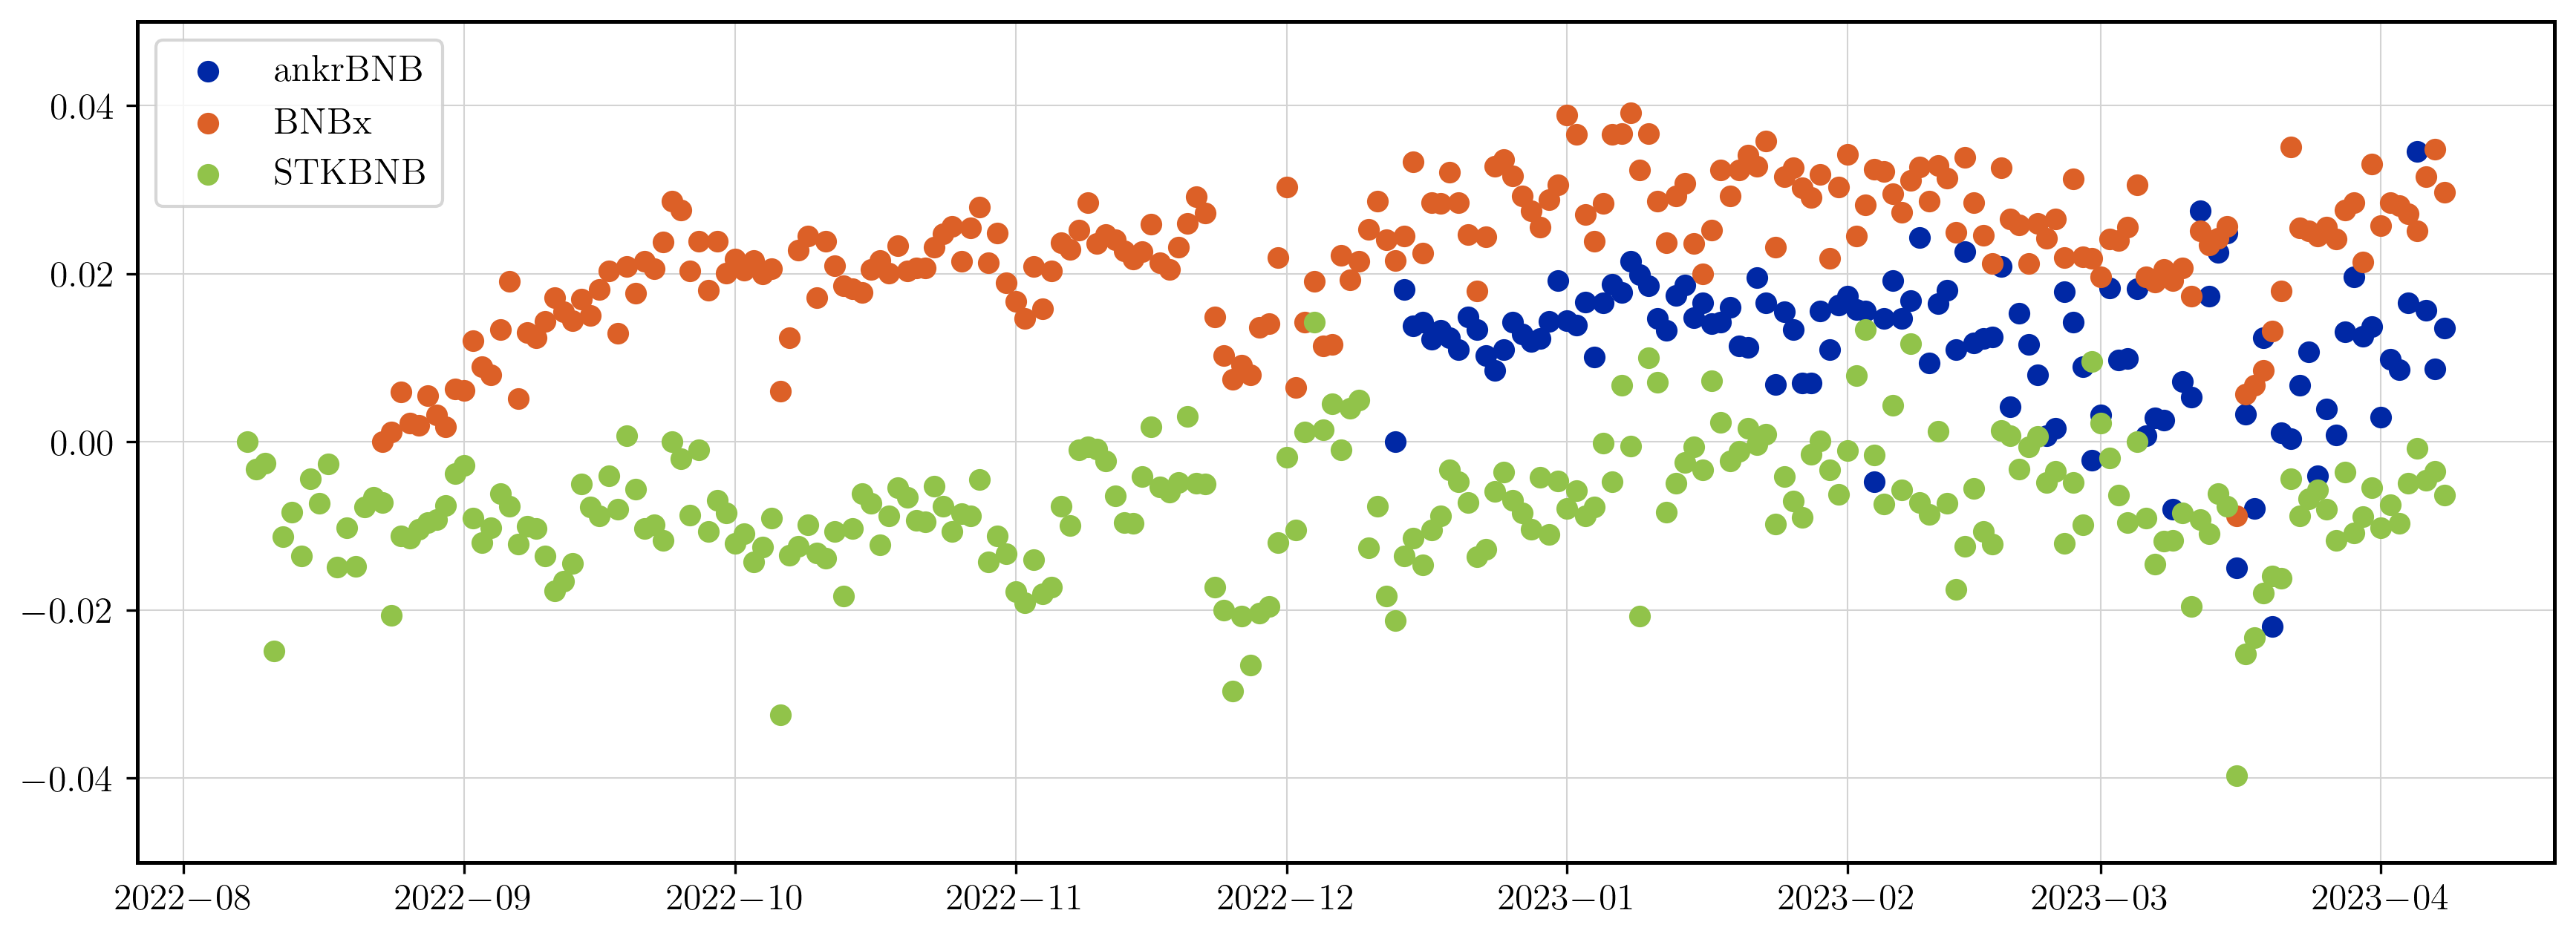

In [42]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = ret_diff
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(14,5),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    ax.scatter(data_to_plot[col].index, data_to_plot[col], lw=1, label = col)

#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
ax.set_ylim(-0.05,0.05)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [43]:
excess_returns.describe()

,ankrBNB,BNBx,STKBNB,daily,daily_accrued
count,116.000000,228.000000,243.000000,244.000000,244.000000
mean,0.000159,0.000141,0.000001,0.000081,1.009986
std,0.009505,0.005611,0.007324,0.000000,0.005773
min,-0.038205,-0.032958,-0.031695,0.000081,1.000081
25%,-0.003739,-0.002451,-0.003672,0.000081,1.005013
50%,0.000090,0.000398,-0.000018,0.000081,1.009970
75%,0.004799,0.003416,0.004129,0.000081,1.014951
max,0.023196,0.016499,0.030970,0.000081,1.019956


C:\Users\malte\AppData\Local\Temp/ipykernel_12872/2208906254.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels)
No handles with labels found to put in legend.


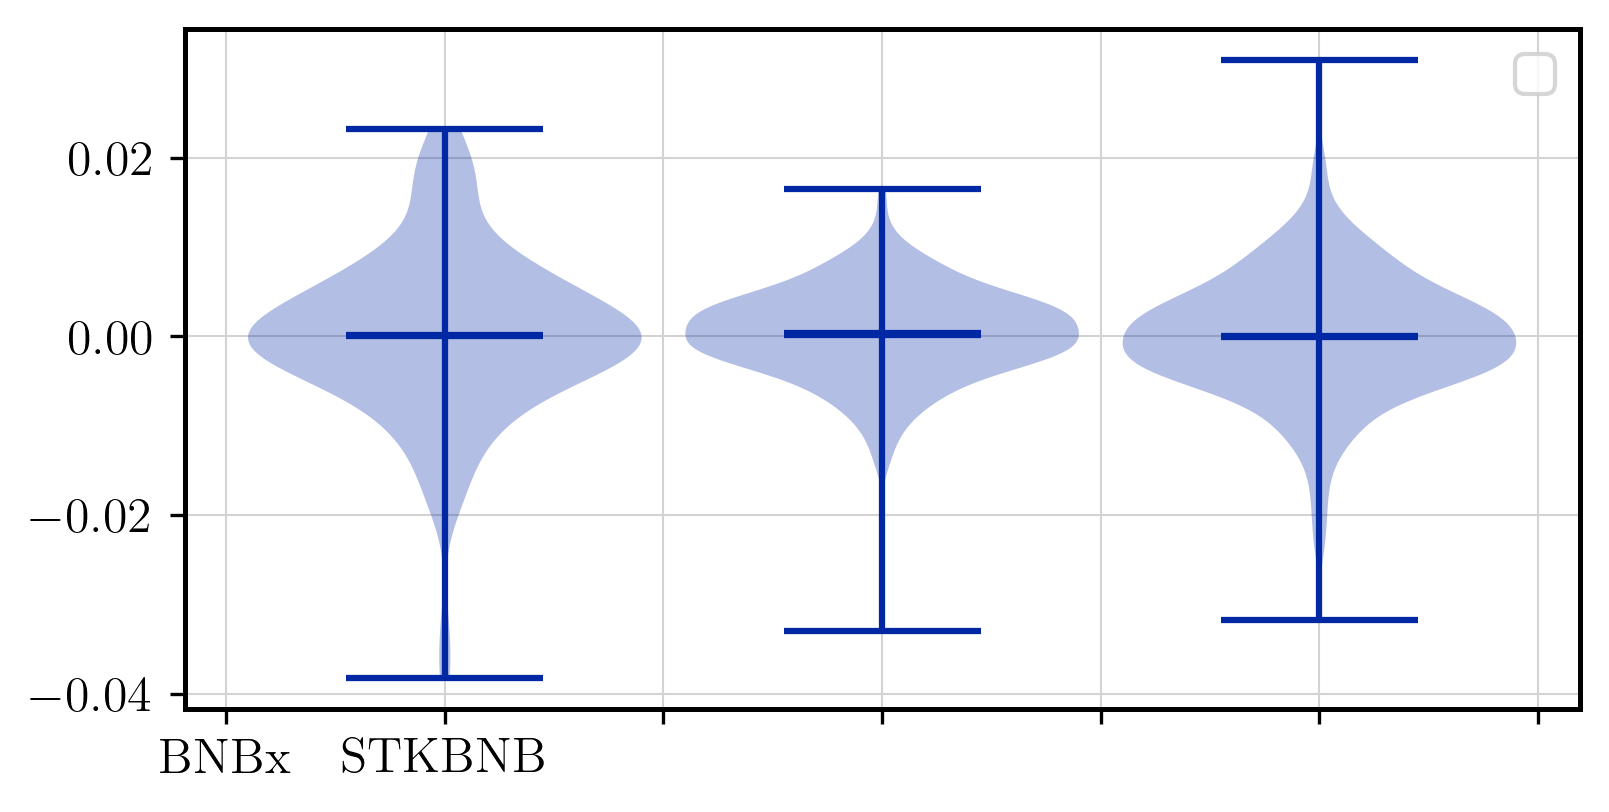

In [44]:
from scipy import signal
#detrended = signal.detrend(df['Number of Passengers'].values)


data_to_plot = excess_returns
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,3),dpi =300)

violin = []
labels = []
for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    violin.append(data_to_plot[data_to_plot[col].notna()][col].values)
    labels.append(col)

vplot = ax.violinplot(violin, positions=None, widths=0.9, showmeans=True, showextrema=True, showmedians=True, points=300, bw_method=None)
ax.set_xticklabels(labels)
#ax.plot(data_to_plot.index, data_to_plot['daily_accrued'], lw=1, ls='--', label='Effective Stake')

ax.set_axisbelow(True)
#ax.set_ylim(-0.05,0.05)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

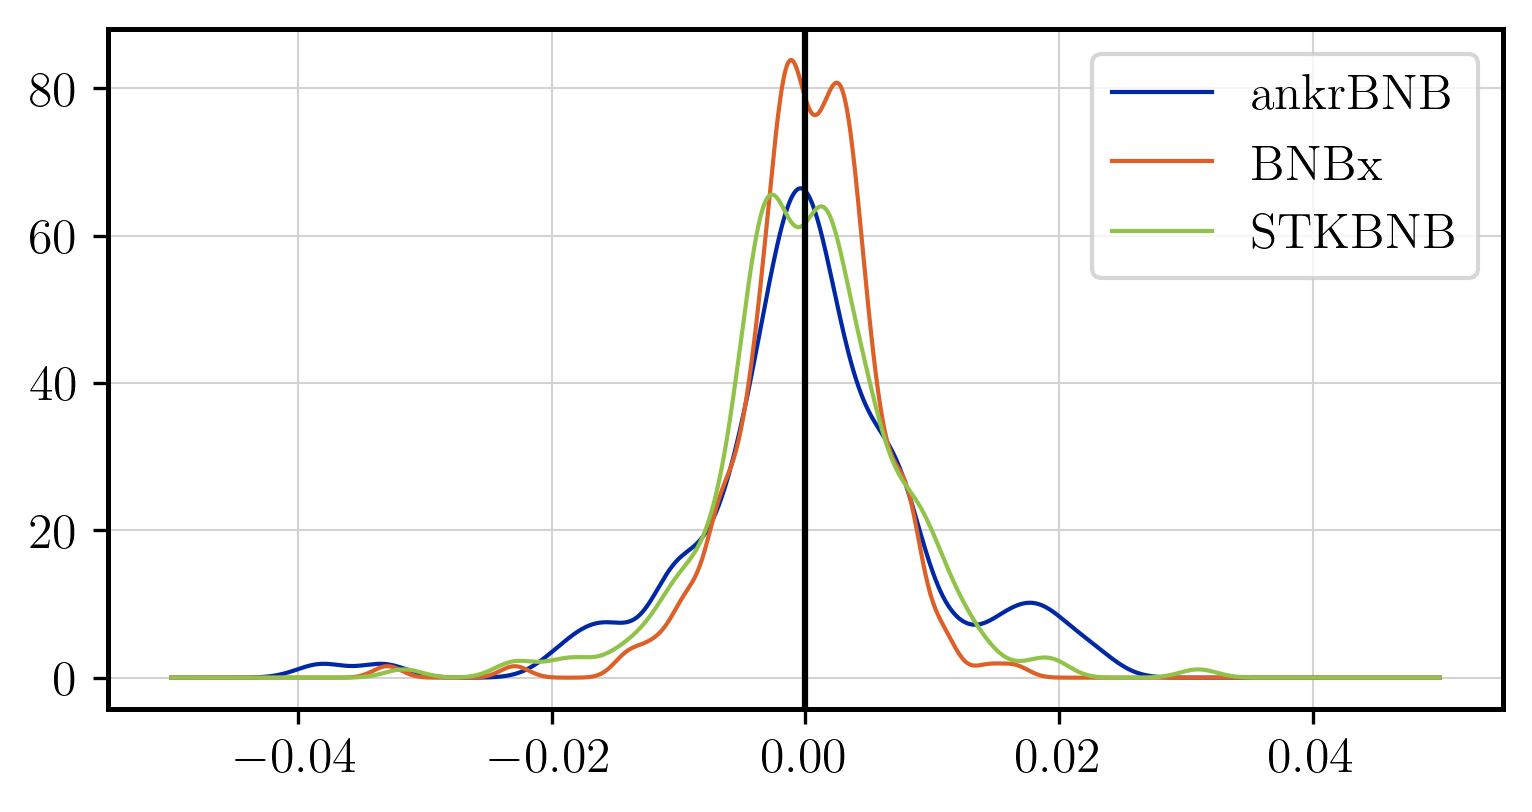

In [45]:
from scipy.stats import gaussian_kde


data_to_plot = excess_returns
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,3),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    d = data_to_plot[data_to_plot[col].notnull()][col].values
    density = gaussian_kde(d)

    density.covariance_factor = lambda : 0.2
    density._compute_covariance()
    x = np.linspace(-0.05,0.05,1000)
    
    line = ax.plot(x,density(x),lw=1, label=col)
    #ax.fill_between(x,0,density(x), alpha = 0.1, color = line[0].get_color())

ax.axvline(0, color='k')
ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

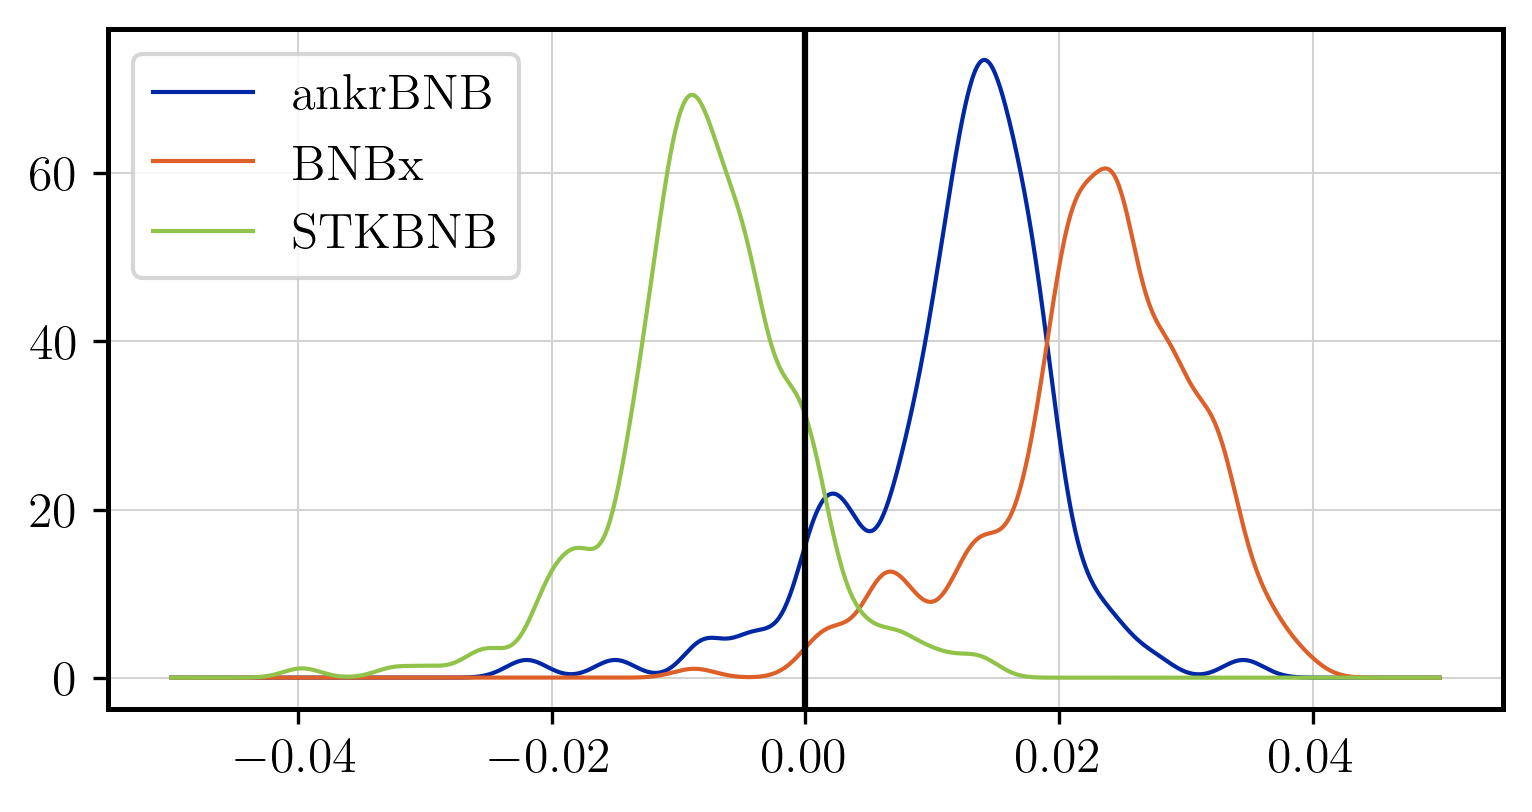

In [46]:
from scipy.stats import gaussian_kde


data_to_plot = ret_diff
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(6,3),dpi =300)

for col in data_to_plot:
    if col in ['daily', 'daily_accrued']:
        continue
    d = data_to_plot[data_to_plot[col].notnull()][col].values
    density = gaussian_kde(d)

    density.covariance_factor = lambda : 0.2
    density._compute_covariance()
    x = np.linspace(-0.05,0.05,1000)
    
    line = ax.plot(x,density(x),lw=1, label=col)
    #ax.fill_between(x,0,density(x), alpha = 0.1, color = line[0].get_color())

ax.axvline(0, color='k')
ax.set_axisbelow(True)
ax.legend()
ax.grid(zorder=100, lw =0.5, color = 'lightgray')
fig.set_facecolor('w')

In [47]:
data_reg = pd.concat([excess_returns, interest.daily_BNB_change, interest.monthly_BNB_std, interest.daily_BNB_std_change, np.log(interest.market_cap), np.log(interest.total_volume)], axis=1, join="inner")
#for col in ['wstBNB', 'rBNB', 'cbBNB', 'sfrxBNB', 'ankrBNB']:
#    data_reg[col] = adjusted_results[col].pct_change(1)
data_reg

,ankrBNB,BNBx,STKBNB,daily,daily_accrued,daily_BNB_change,monthly_BNB_std,daily_BNB_std_change,market_cap,total_volume
2022-08-08,NaN,NaN,NaN,0.000081,1.000081,0.024463,0.033435,0.002657,24.688633,20.077496
2022-08-09,NaN,NaN,-0.003247,0.000081,1.000162,0.005252,0.033413,-0.000641,24.693600,20.667929
2022-08-10,NaN,NaN,0.000675,0.000081,1.000243,0.001818,0.032400,-0.030331,24.697192,20.894557
2022-08-11,NaN,NaN,-0.022392,0.000081,1.000324,0.006902,0.031069,-0.041073,24.702787,19.327496
2022-08-12,NaN,NaN,0.013988,0.000081,1.000405,-0.012566,0.030839,-0.007402,24.690728,19.958307
...,...,...,...,...,...,...,...,...,...,...
2023-04-04,0.007678,-0.000925,0.004674,0.000081,1.019626,-0.016764,0.027050,0.008122,24.611713,20.432340
2023-04-05,0.017362,-0.001921,0.004090,0.000081,1.019709,0.006936,0.027048,-0.000070,24.616862,20.307508
2023-04-06,-0.017880,0.006198,-0.003650,0.000081,1.019791,0.010574,0.027067,0.000715,24.628096,20.214232
2023-04-07,-0.006730,0.003115,0.001036,0.000081,1.019874,-0.006071,0.027120,0.001941,24.621511,20.010734


In [48]:
data_auto_reg = pd.concat([ret_diff, interest.daily_BNB_change, interest.monthly_BNB_std,interest.daily_BNB_std_change, np.log(interest.market_cap), np.log(interest.total_volume)], axis=1, join="inner")
for col in tokens:
    data_auto_reg['shift1_'+str(col)] = data_auto_reg[col].shift(1)
    data_auto_reg['shift2_'+str(col)] = data_auto_reg[col].shift(2)
    data_auto_reg['shift3_'+str(col)] = data_auto_reg[col].shift(3)
    data_auto_reg['shift4_'+str(col)] = data_auto_reg[col].shift(4)
    data_auto_reg['shift5_'+str(col)] = data_auto_reg[col].shift(5)
    data_auto_reg['shift6_'+str(col)] = data_auto_reg[col].shift(6)
data_auto_reg

,ankrBNB,BNBx,STKBNB,daily,daily_accrued,daily_BNB_change,monthly_BNB_std,daily_BNB_std_change,market_cap,total_volume,...,shift3_BNBx,shift4_BNBx,shift5_BNBx,shift6_BNBx,shift1_STKBNB,shift2_STKBNB,shift3_STKBNB,shift4_STKBNB,shift5_STKBNB,shift6_STKBNB
2022-08-08,NaN,NaN,0.000000,0.000081,1.000081,0.024463,0.033435,0.002657,24.688633,20.077496,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-08-09,NaN,NaN,-0.003248,0.000081,1.000162,0.005252,0.033413,-0.000641,24.693600,20.667929,...,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,NaN,NaN,NaN
2022-08-10,NaN,NaN,-0.002575,0.000081,1.000243,0.001818,0.032400,-0.030331,24.697192,20.894557,...,NaN,NaN,NaN,NaN,-0.003248,0.000000,NaN,NaN,NaN,NaN
2022-08-11,NaN,NaN,-0.024915,0.000081,1.000324,0.006902,0.031069,-0.041073,24.702787,19.327496,...,NaN,NaN,NaN,NaN,-0.002575,-0.003248,0.000000,NaN,NaN,NaN
2022-08-12,NaN,NaN,-0.011273,0.000081,1.000405,-0.012566,0.030839,-0.007402,24.690728,19.958307,...,NaN,NaN,NaN,NaN,-0.024915,-0.002575,-0.003248,0.000000,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-04-04,0.016529,0.027095,-0.004957,0.000081,1.019626,-0.016764,0.027050,0.008122,24.611713,20.432340,...,0.025686,0.033080,0.021411,0.028500,-0.009676,-0.007446,-0.010241,-0.005420,-0.008860,-0.010816
2023-04-05,0.034520,0.025087,-0.000807,0.000081,1.019709,0.006936,0.027048,-0.000070,24.616862,20.307508,...,0.028420,0.025686,0.033080,0.021411,-0.004957,-0.009676,-0.007446,-0.010241,-0.005420,-0.008860
2023-04-06,0.015673,0.031565,-0.004526,0.000081,1.019791,0.010574,0.027067,0.000715,24.628096,20.214232,...,0.028062,0.028420,0.025686,0.033080,-0.000807,-0.004957,-0.009676,-0.007446,-0.010241,-0.005420
2023-04-07,0.008706,0.034842,-0.003475,0.000081,1.019874,-0.006071,0.027120,0.001941,24.621511,20.010734,...,0.027095,0.028062,0.028420,0.025686,-0.004526,-0.000807,-0.004957,-0.009676,-0.007446,-0.010241


In [49]:
#exclude daily as variable since constant 
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from statsmodels.stats.outliers_influence import variance_inflation_factor
for col in tokens:
    df_reg = data_reg[['daily_BNB_change', 'monthly_BNB_std','daily_BNB_std_change', 'market_cap','total_volume' ,str(col) ]].dropna()
    X = df_reg[['daily_BNB_change', 'monthly_BNB_std','daily_BNB_std_change', 'market_cap', 'total_volume']]
    y = df_reg[str(col)]
    #demean data
    X = X - X.mean()
    X = sm.add_constant(X)
                            
    #Calculate and print variance inflation factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                    for i in range(len(X.columns))]
    print(vif_data)
    model_ols = sm.OLS(y,X)
    ols_res = model_ols.fit(cov_type='HAC', cov_kwds={'maxlags':10})
    print(ols_res.summary())

                feature       VIF
0                 const  1.000000
1      daily_BNB_change  1.025360
2       monthly_BNB_std  1.095742
3  daily_BNB_std_change  1.044035
4            market_cap  1.216278
5          total_volume  1.150644
                            OLS Regression Results                            
Dep. Variable:                ankrBNB   R-squared:                       0.014
Model:                            OLS   Adj. R-squared:                 -0.030
Method:                 Least Squares   F-statistic:                    0.4658
Date:                Mon, 15 May 2023   Prob (F-statistic):              0.801
Time:                        19:30:39   Log-Likelihood:                 376.83
No. Observations:                 116   AIC:                            -741.7
Df Residuals:                     110   BIC:                            -725.1
Df Model:                           5                                         
Covariance Type:                  HAC              

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [50]:
from linearmodels import PanelOLS
from linearmodels import RandomEffects
from statsmodels.stats.outliers_influence import variance_inflation_factor
for col in tokens:
    df_auto_reg = data_auto_reg[['daily_BNB_change', 'monthly_BNB_std', 'market_cap', 'total_volume' ,str(col),'shift1_'+str(col),'daily_BNB_std_change',
                                 'shift2_'+str(col),'shift3_'+str(col),'shift4_'+str(col),'shift5_'+str(col),'shift6_'+str(col) ]].dropna()
    X = df_auto_reg[['shift1_'+str(col),'shift2_'+str(col),'shift3_'+str(col),'shift4_'+str(col),'shift5_'+str(col),'shift6_'+str(col),'daily_BNB_change', 'monthly_BNB_std','daily_BNB_std_change', 'market_cap', 'total_volume']]
    #demean data
    X = X - X.mean()
    y = df_auto_reg[str(col)]
    X = sm.add_constant(X)
                        
    #Calculate and print variance inflation factor (VIF)
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i)
                    for i in range(len(X.columns))]
    print(vif_data)
    model_ols = sm.OLS(y,X)
    ols_res = model_ols.fit(cov_type='HAC', cov_kwds={'maxlags':10}) 
    print(ols_res.summary())

                 feature       VIF
0                  const  1.000000
1         shift1_ankrBNB  1.210040
2         shift2_ankrBNB  1.277139
3         shift3_ankrBNB  1.317298
4         shift4_ankrBNB  1.319645
5         shift5_ankrBNB  1.239397
6         shift6_ankrBNB  1.274680
7       daily_BNB_change  1.102700
8        monthly_BNB_std  1.061871
9   daily_BNB_std_change  1.114221
10            market_cap  1.347236
11          total_volume  1.249540
                            OLS Regression Results                            
Dep. Variable:                ankrBNB   R-squared:                       0.182
Model:                            OLS   Adj. R-squared:                  0.092
Method:                 Least Squares   F-statistic:                     13.21
Date:                Mon, 15 May 2023   Prob (F-statistic):           4.05e-15
Time:                        19:30:54   Log-Likelihood:                 387.14
No. Observations:                 111   AIC:                           

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
